# Predicción de lluvia en Australia

### 1. Introducción y objetivos

Durante el trabajo se utilizará un dataset llamado weatherAUS.csv que contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia, en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’ respectivamente.

El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.

Para ello nos valdremos de la biblioteca scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos y la evaluación de métricas, con TensorFlow para el entrenamiento de redes neuronales y con Docker para la puesta en producción del modelo seleccionado como el más adecuado, entre otras.

El dataset contiene información sobre distintas ciudades, las cuales se encuentran en la columna ‘Location’. Solamente se utilizarán para las predicciones las siguientes: Albury, Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport.

### 2. Dependencias utilizadas

In [188]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\franc\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [189]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import folium
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Evaluación de modelos
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_curve

# Regresión
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed # ejecutación de código en paralelo
from tqdm import tqdm # barra de progreso
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score

# Redes Neuronales
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Flatten, Dense # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.metrics import Recall # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from keras.losses import MeanSquaredError, BinaryCrossentropy # type: ignore
from keras.metrics import MeanSquaredError as MSE # type: ignore
import optuna

#Explicabilidad
import shap

In [190]:
semilla = 37

### 3. Preprocesamiento de datos (df_train)

#### Carga de datos

In [191]:
# Carga del csv
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [192]:
# Se elimina la primera columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [193]:
# Se genera un dataframe reducido que contiene las ciudades de interés (df), pero se conserva el df original (ahora df_full).
df_full = df.copy()

# Lista de ubicaciones admitidas
locations = ['Albury', 'Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']

# Filtrar el dataframe para mantener solo las ubicaciones admitidas
df = df[df['Location'].isin(locations)]

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19025 entries, 0 to 70370
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              19025 non-null  object 
 1   Location          19025 non-null  object 
 2   MinTemp           18523 non-null  float64
 3   MaxTemp           18528 non-null  float64
 4   Rainfall          18209 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       17536 non-null  object 
 8   WindGustSpeed     17538 non-null  float64
 9   WindDir9am        17805 non-null  object 
 10  WindDir3pm        18690 non-null  object 
 11  WindSpeed9am      18755 non-null  float64
 12  WindSpeed3pm      18765 non-null  float64
 13  Humidity9am       18446 non-null  float64
 14  Humidity3pm       18492 non-null  float64
 15  Pressure9am       18285 non-null  float64
 16  Pressure3pm       18291 non-null  float64
 17

In [195]:
# Se comprueba la cantidad de nulos
df.isnull().sum()

Date                   0
Location               0
MinTemp              502
MaxTemp              497
Rainfall             816
Evaporation         4745
Sunshine            4987
WindGustDir         1489
WindGustSpeed       1487
WindDir9am          1220
WindDir3pm           335
WindSpeed9am         270
WindSpeed3pm         260
Humidity9am          579
Humidity3pm          533
Pressure9am          740
Pressure3pm          734
Cloud9am            4428
Cloud3pm            4545
Temp9am              514
Temp3pm              504
RainToday            816
RainTomorrow         816
RainfallTomorrow     816
dtype: int64

Tratamiento de faltantes en las columnas target

In [196]:
# Obtener los índices de los valores faltantes en cada columna
null_RainTomorrow = df[df['RainTomorrow'].isna()].index
null_RainfallTomorrow = df[df['RainfallTomorrow'].isna()].index

# Comparar si los índices de los valores faltantes son los mismos
coinciden2 = null_RainTomorrow.equals(null_RainfallTomorrow)

#print(f"¿Los registros faltantes coinciden? {coinciden1}")
print(f"¿Los registros faltantes coinciden? {coinciden2}")

¿Los registros faltantes coinciden? True


In [197]:
# Se eliminan los registros donde RainfallTomorrow y RainTomorrow tienen valores faltantes (816)
df = df.dropna(subset=['RainfallTomorrow', 'RainTomorrow'])
df.isnull().sum()

Date                   0
Location               0
MinTemp               16
MaxTemp                7
Rainfall             183
Evaporation         4704
Sunshine            4949
WindGustDir         1455
WindGustSpeed       1453
WindDir9am          1195
WindDir3pm           330
WindSpeed9am         264
WindSpeed3pm         256
Humidity9am           92
Humidity3pm           49
Pressure9am          253
Pressure3pm          249
Cloud9am            3770
Cloud3pm            3878
Temp9am               28
Temp3pm               20
RainToday            183
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

Transformación de RainToday y RainTomorrow: Conversión a tipo booleano.

In [198]:
# Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

#### Partición del Dataframe

Se particiona el df en una proporción aproximada de 70% 15% 15%, correspondiendo los datos del df_train a los datos cronológicamente más antiguos.

In [199]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular los índices que corresponden al 70% y 85% del DataFrame
index_at_70_percent = int(len(df) * 0.7)
index_at_85_percent = int(len(df) * 0.85)

# Usar los índices para obtener las fechas en esos puntos
date_at_70_percent = df.iloc[index_at_70_percent]['Date']
date_at_85_percent = df.iloc[index_at_85_percent]['Date']

# Crear df_train, df_val y df_test basado en estas fechas
df_train = df[df['Date'] <= date_at_70_percent]
df_val = df[(df['Date'] > date_at_70_percent) & (df['Date'] <= date_at_85_percent)]
df_test = df[df['Date'] > date_at_85_percent]

# Almacenar los largos de df_train, df_val y df_test
df_train_len = len(df_train)
df_val_len = len(df_val)
df_test_len = len(df_test)

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {df_train_len} registros")
print(f"Validación: {df_val_len} registros")
print(f"Prueba: {df_test_len} registros")
print(f"Suma de registros (Entrenamiento + Validación + Prueba): {df_train_len + df_val_len + df_test_len} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")

Entrenamiento: 12749 registros
Validación: 2729 registros
Prueba: 2731 registros
Suma de registros (Entrenamiento + Validación + Prueba): 18209 registros
Cantidad total de registros en df original: 18209 registros


#### Exploración de los datos en df_train

In [200]:
def hist_sns(df, bins=20, kde=True, figsize=(15, 10)):
    """
    Genera histogramas para todas las columnas numéricas de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas
    - bins: Número de intervalos en el histograma
    - kde: Si es True, añade una curva de densidad (KDE)
    - figsize: Tamaño de la figura
    """
    # Filtrar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

    # Calcular el número de filas y columnas para los subgráficos
    n = len(columnas_numericas)
    ncols = 3  # Número de columnas de subgráficos
    nrows = (n // ncols) + (1 if n % ncols != 0 else 0)  # Número de filas necesarias

    # Crear la figura y los subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout(pad=4.0)  # Espacio entre subgráficos

    # Convierte la matriz en un array plano para facilitar la iteración
    axes = axes.flatten()

    # Iterar sobre las columnas numéricas y graficar histogramas
    for i, col in enumerate(columnas_numericas):
        sns.histplot(df[col], ax=axes[i], bins=bins, kde=kde, color='skyblue')
        axes[i].set_title(f'Histograma de {col}')
        axes[i].set_xlabel('Valores')
        axes[i].set_ylabel('Frecuencia')

    # Ocultar ejes vacíos si hay más subgráficos que columnas
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

In [201]:
def boxplot_sns(df, figsize=(15, 10)):
    """
    Genera diagramas de caja para todas las columnas numéricas del DataFrame que recibe como argumento.

    Parámetros:
    - df: DataFrame de pandas
    - figsize: Tamaño de la figura
    """
    # Filtrar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

    # Calcular el número de filas y columnas para los subgráficos
    n = len(columnas_numericas)
    ncols = 3  # Número de columnas de subgráficos
    nrows = (n // ncols) + (1 if n % ncols != 0 else 0)  # Número de filas necesarias

    # Crear la figura y los subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout(pad=4.0)  # Espacio entre subgráficos

    # Convierte la matriz en un array plano para facilitar la iteración
    axes = axes.flatten()

    # Iterar sobre las columnas numéricas y graficar boxplots
    for i, col in enumerate(columnas_numericas):
        sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
        axes[i].set_title(f'Boxplot de {col}')
        axes[i].set_xlabel('Valores')

    # Ocultar ejes vacíos si hay más subgráficos que columnas
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

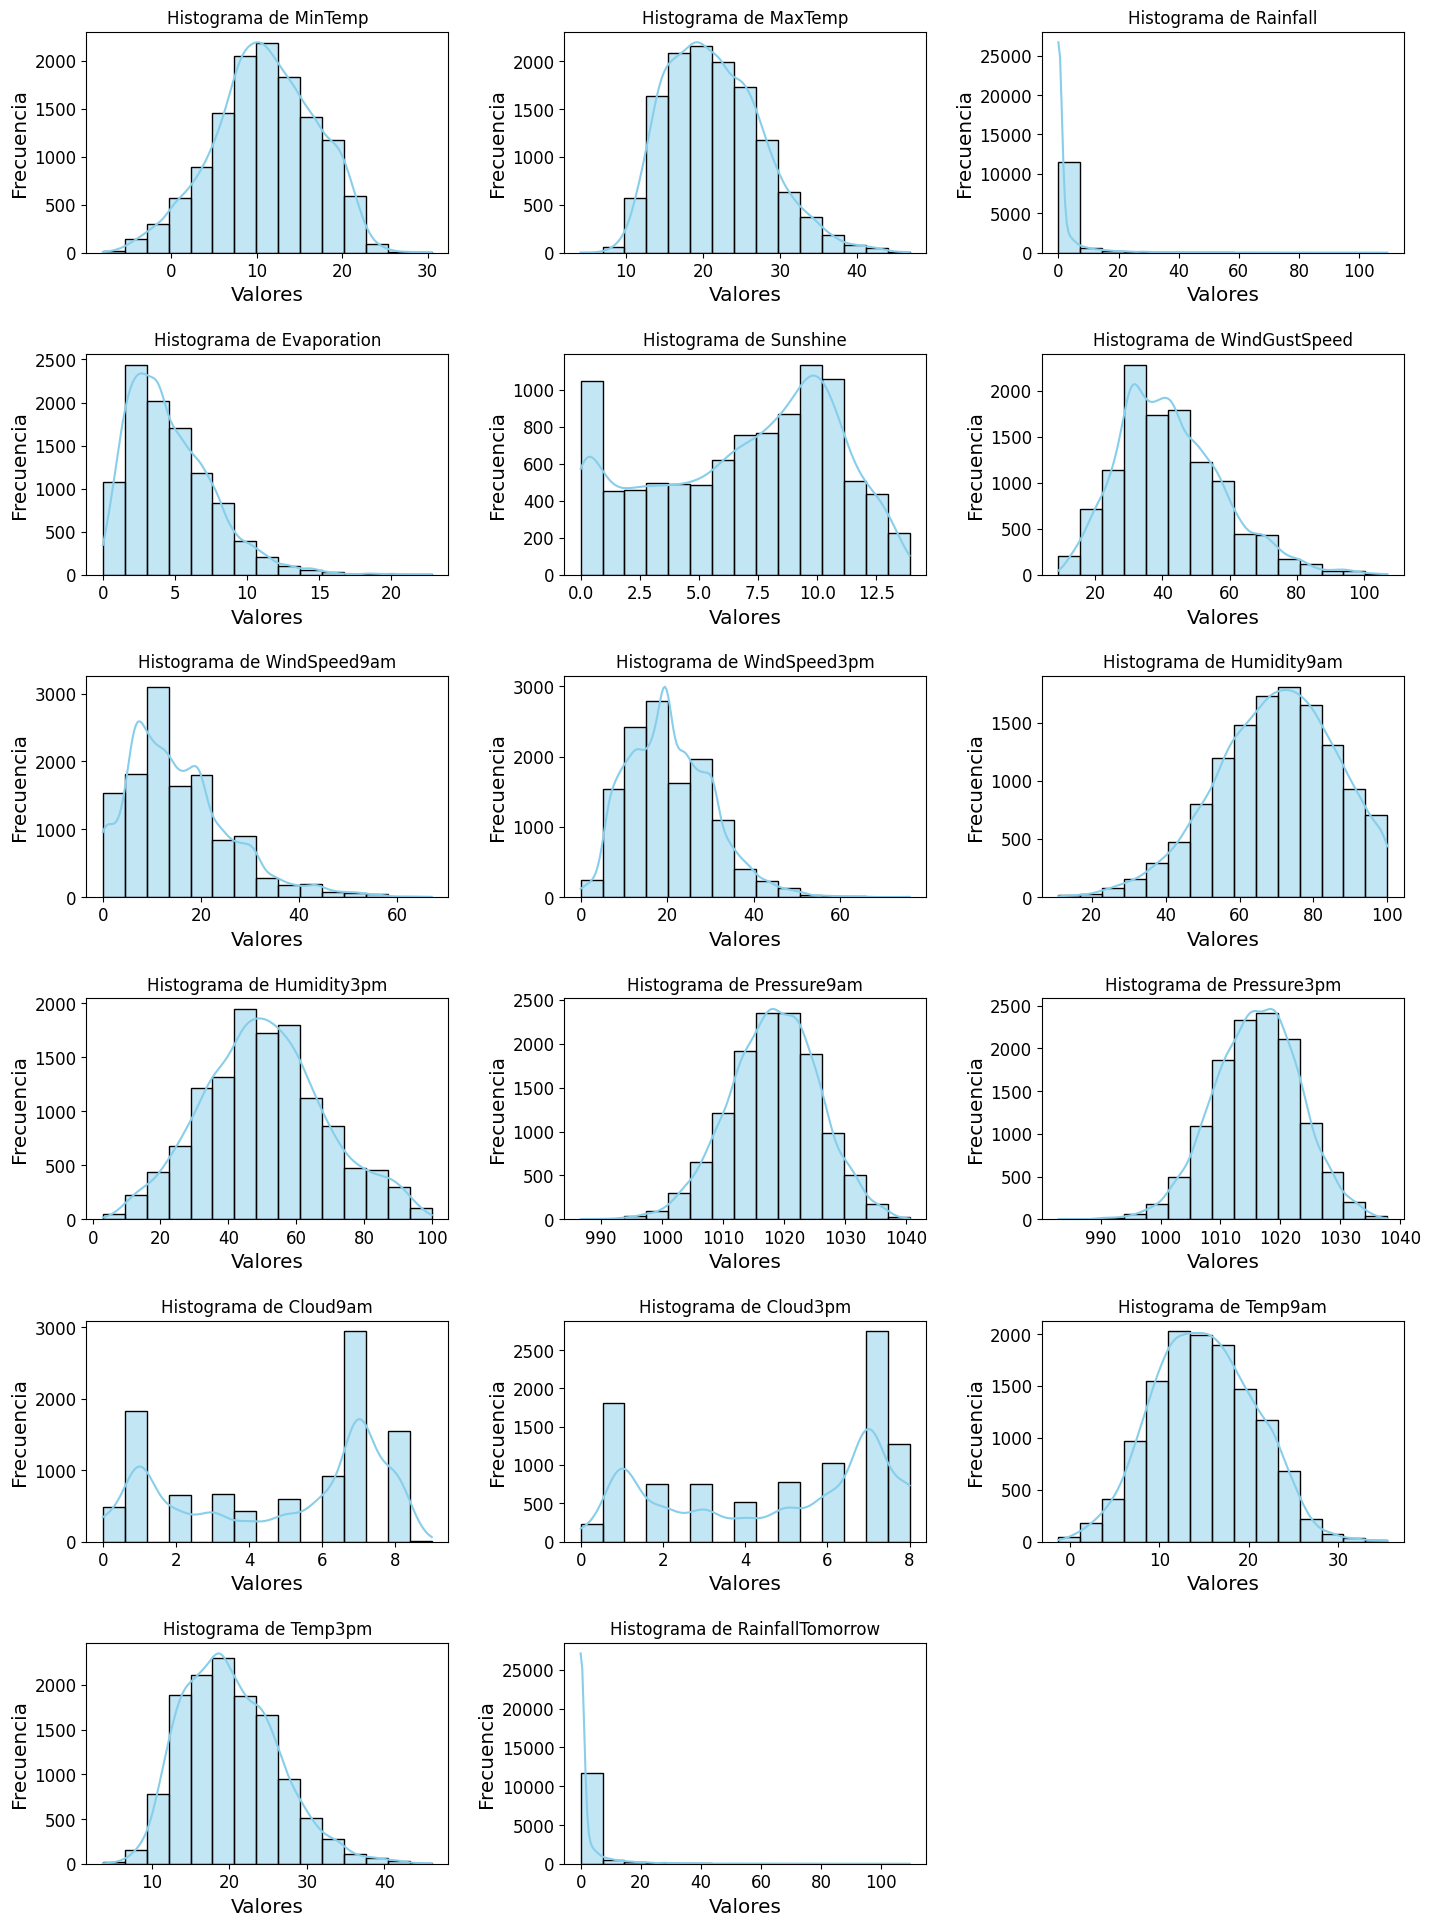

In [202]:
hist_sns(df_train, bins=15, kde=True, figsize=(15, 20))

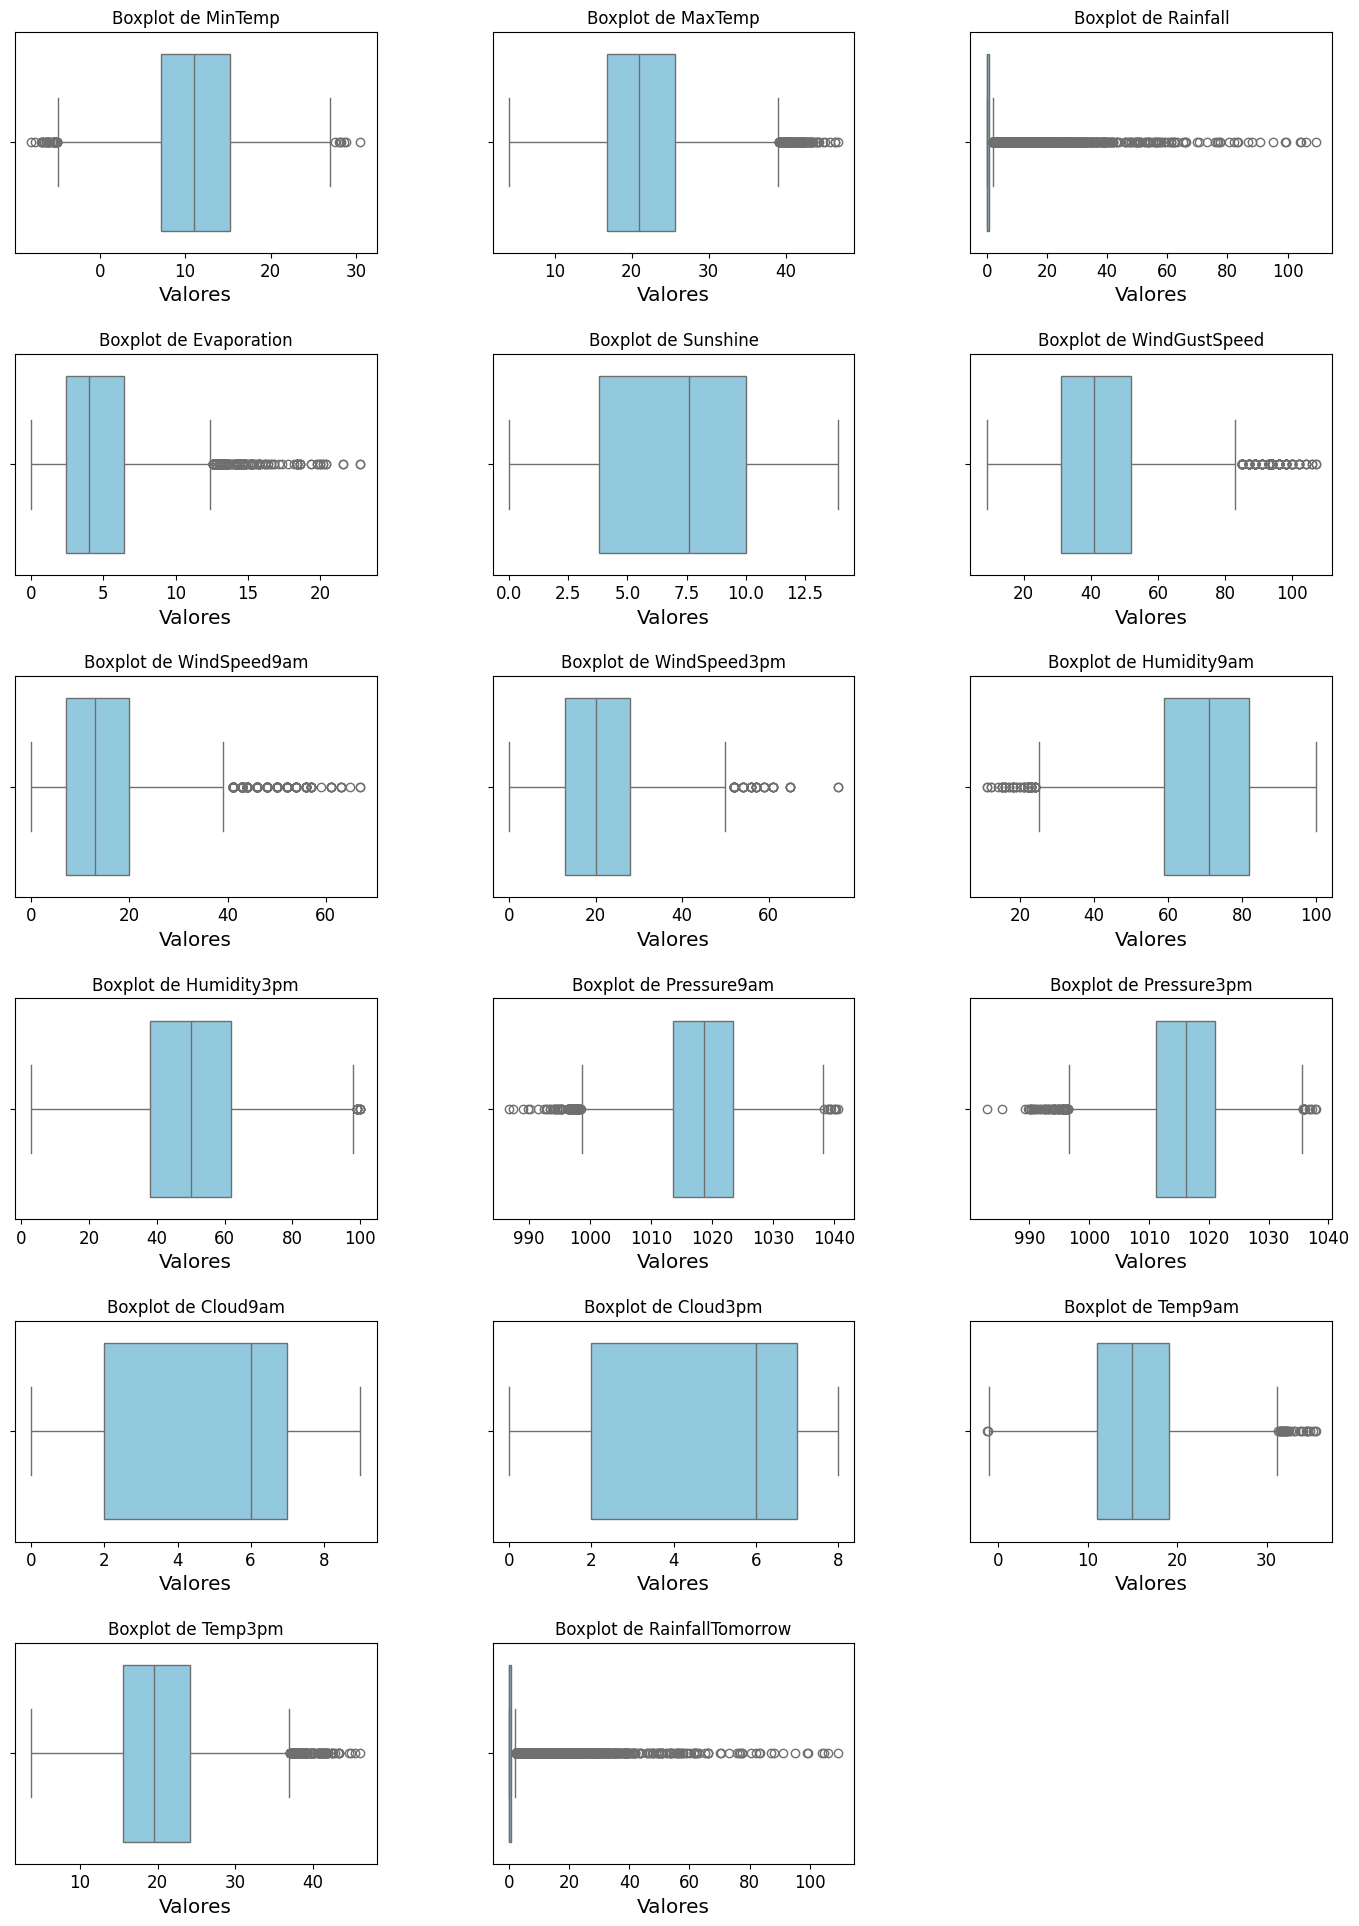

In [203]:
boxplot_sns(df_train, figsize=(15, 20))

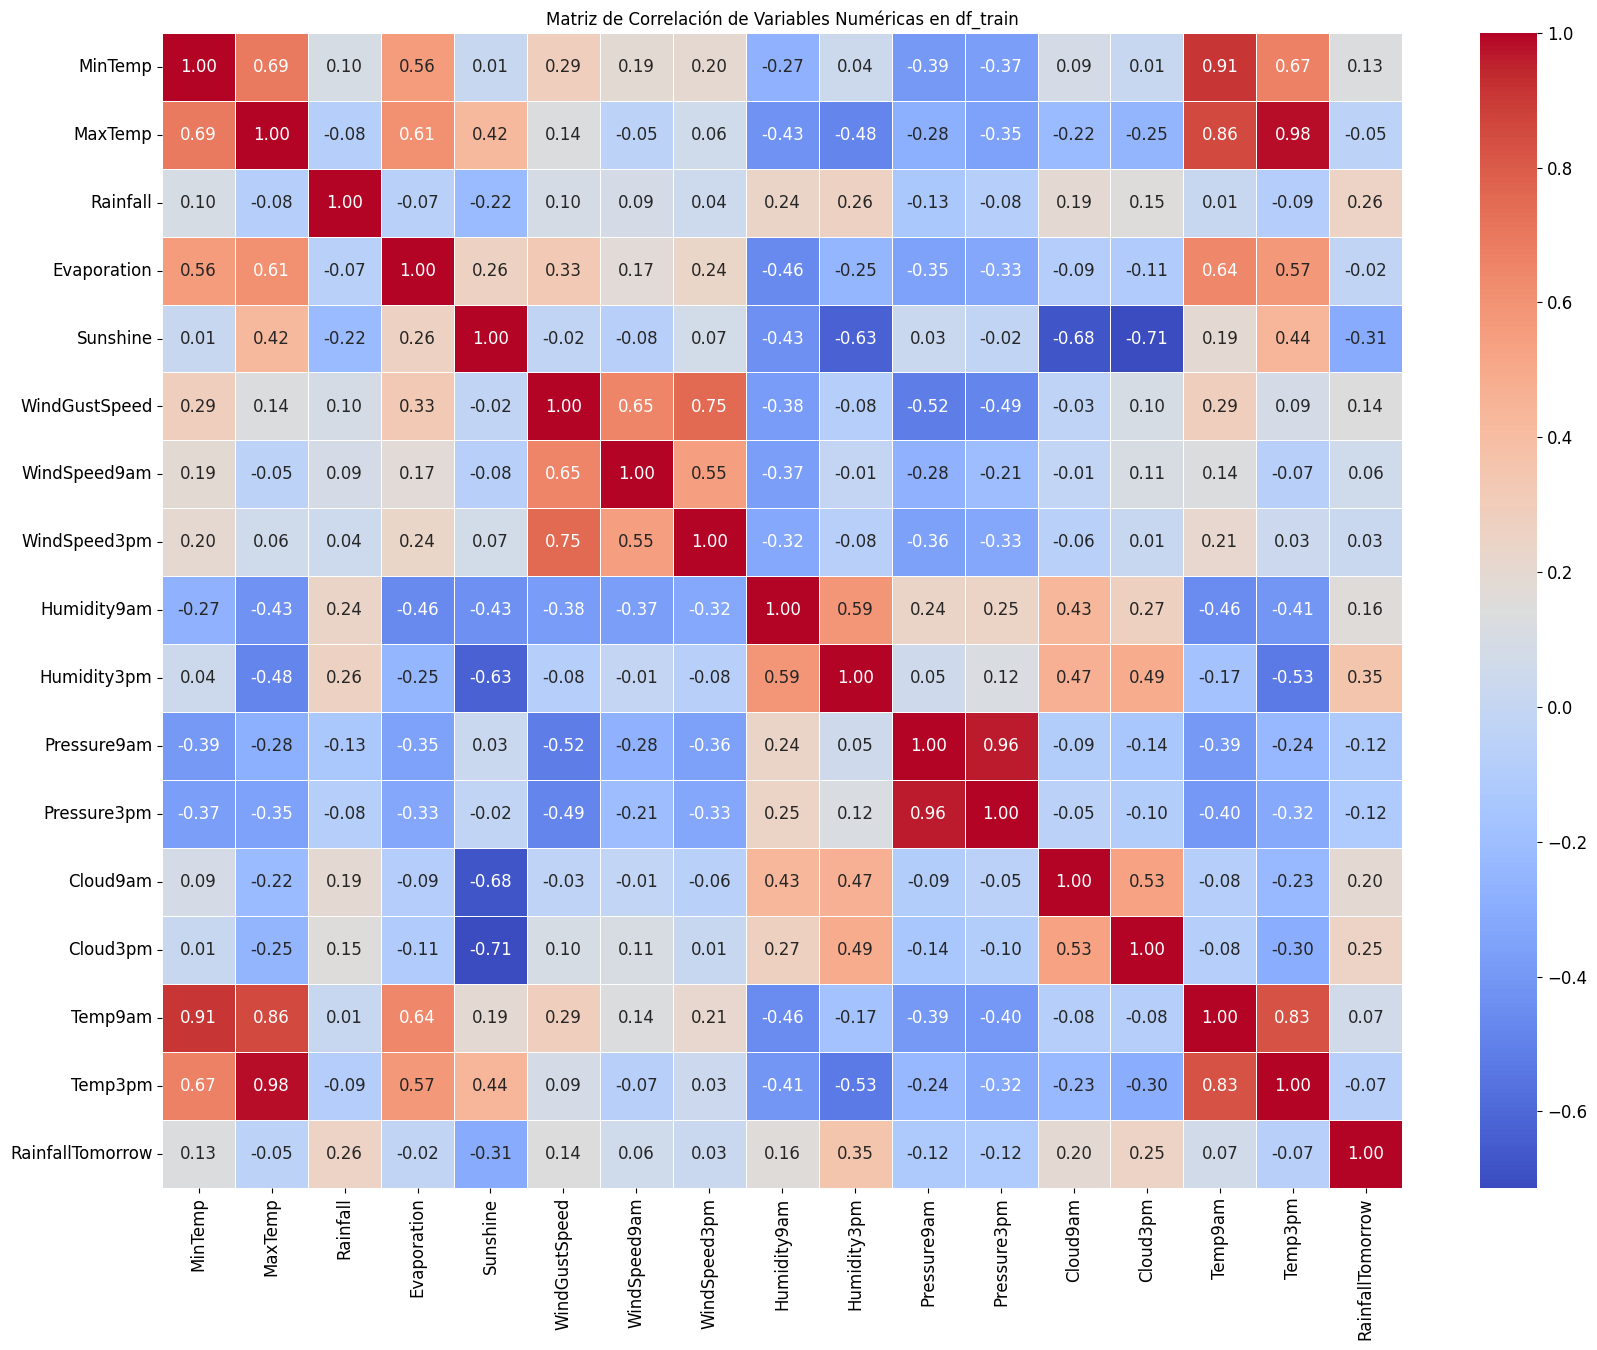

In [204]:
# Heatmap de matriz de correlación (sólo columnas numéricas)
df_numeric = df_train.select_dtypes(include=['float64', 'int64'])
matriz_correlacion = df_numeric.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas en df_train')
plt.show()

Se encuentran correlaciones muy altas (arriba de 0.9) entre MaxTemp y Temp3pm, Pressure9am y Pressure3pm, y MinTemp y Temp9am. Se eliminan las variables Temp9am, Temp3pm y Pressure9am.   

In [205]:
df_train = df_train.drop(columns=['Temp9am'])
df_train = df_train.drop(columns=['Temp3pm'])
df_train = df_train.drop(columns=['Pressure9am'])

In [206]:
df_train.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow',
       'RainfallTomorrow'],
      dtype='object')

#### Balance de los datos target

In [207]:
# Contar el número de ocurrencias de cada categoría en la columna 'RainTomorrow'
conteo_categorias = df_train['RainTomorrow'].value_counts() # False 9814 vs. True 2935

# Calcular la proporción de cada categoría
proporcion_no = round(conteo_categorias[0] / len(df_train), 2)
proporcion_yes = round(conteo_categorias[1] / len(df_train), 2)
print("Proporción de 'RainTomorrow' igual a 0 (No):", proporcion_no)
print("Proporción de 'RainTomorrow' igual a 1 (Yes):", proporcion_yes)

Proporción de 'RainTomorrow' igual a 0 (No): 0.77
Proporción de 'RainTomorrow' igual a 1 (Yes): 0.23


Se observa que el conjunto de datos está desbalanceado, con una gran disparidad entre las clases 0 y 1 de RainTomorrow. Esto puede sesgar los modelos de ML hacia la clase mayoritaria, afectando su capacidad para predecir correctamente la clase minoritaria.

#### Tratamiento de valores atípicos en df_train

Se analizan los valores atípicos de **Rainfall** y **Evaporation**.

*Nota: Se admite un máximo del 5% de los datos para ser eliminados, ya sea por la presencia de valores atípicos o valores nulos.*

##### **Rainfall**

Para la variable Rainfall, se calcula la proporción de valores que superan a la media más 3 desviaciones standard:

In [208]:
# Calcula el límite superior, que es la media más 3 desviaciones estándar
upper_limit = df_train['Rainfall'].mean() + 3 * df_train['Rainfall'].std()
# Usa este límite para contar cuántos valores están por encima
count_above_upper_limit = (df_train['Rainfall'] > upper_limit).sum()
print(f"Proporción de valores sobre 3 desviaciones stantard para 'Rainfall': {count_above_upper_limit/df_train_len}")

Proporción de valores sobre 3 desviaciones stantard para 'Rainfall': 0.02031531884853714


Se remueve sólo el 1% de los datos (no el 2%) para dejar un margen disponible de datos a borrar.

In [209]:
df_train_sorted = df_train.sort_values(by='Rainfall', ascending=False) # Ordenar df_train por 'Rainfall' descendente
num_to_remove = int(len(df_train) * 0.01) # Calcular la cantidad de filas a eliminar (1% del total)
df_train_filtered = df_train_sorted.iloc[num_to_remove:] # Eliminar solo el 1% más alto
print(f"Cantidad de filas después de eliminar atípicos: {len(df_train_filtered)}")

Cantidad de filas después de eliminar atípicos: 12622


***Comparación de distribuciones***

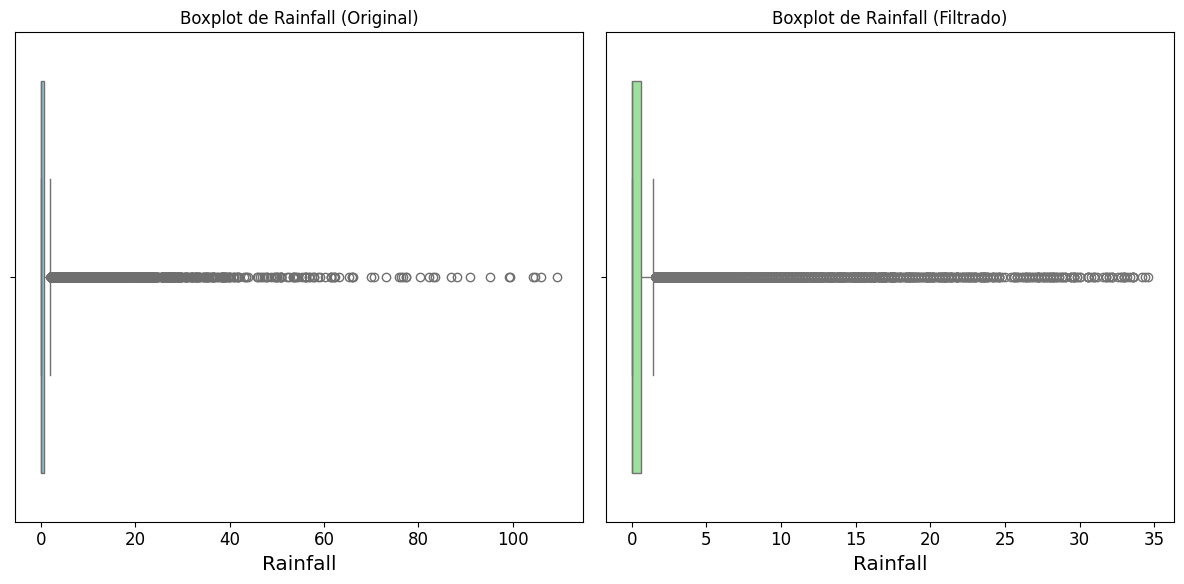

In [210]:
plt.figure(figsize=(12, 6))
# Boxplot de 'Rainfall' en df_train
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subgráfico
sns.boxplot(x=df_train['Rainfall'], color='skyblue')
plt.title('Boxplot de Rainfall (Original)')
plt.xlabel('Rainfall')

# Boxplot de 'Rainfall' en df_train_filtered
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subgráfico
sns.boxplot(x=df_train_filtered['Rainfall'], color='lightgreen')
plt.title('Boxplot de Rainfall (Filtrado)')
plt.xlabel('Rainfall')

# Ajustar el espacio entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Se observa una mejora en la distribución de los datos ✅

In [211]:
# Se actualiza df_train
df_train=df_train_filtered

##### **Evaporation**

In [212]:
# Calcula el límite superior, que es la media más 3 desviaciones estándar
upper_limit = df_train['Evaporation'].mean() + 3 * df_train['Evaporation'].std()
# Usa este límite para contar cuántos valores están por encima
count_above_upper_limit = (df['Evaporation'] > upper_limit).sum()
print(f"Proporción de valores sobre 3 desviaciones stantard para 'Evaporation': {count_above_upper_limit/df_train_len}")

Proporción de valores sobre 3 desviaciones stantard para 'Evaporation': 0.013648129265040396


Se remueve sólo el 1% de los datos (no el 1.36%), para dejar un margen disponible de datos a borrar.

In [213]:
df_train_sorted = df_train.sort_values(by='Evaporation', ascending=False) # Ordenar df_train por 'Evaporation' descendente
num_to_remove = int(len(df_train) * 0.01) # Calcular la cantidad de filas a eliminar (1% del total)
df_train_filtered = df_train_sorted.iloc[num_to_remove:] # Eliminar solo el 1% más alto
print(f"Cantidad de filas después de eliminar atípicos: {len(df_train_filtered)}")

Cantidad de filas después de eliminar atípicos: 12496


***Comparación de distribuciones***

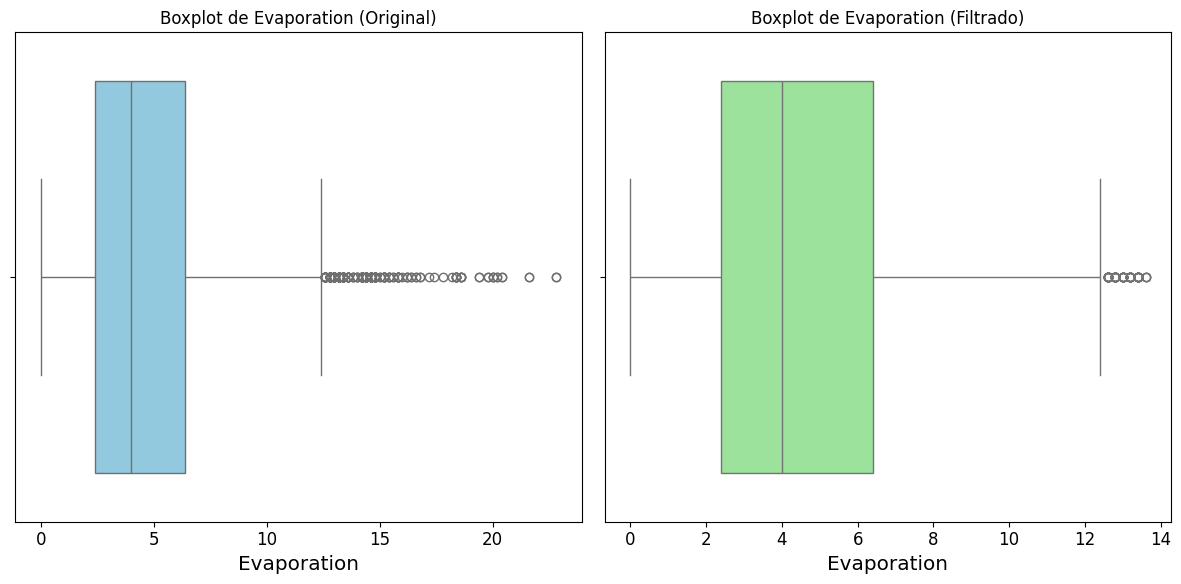

In [214]:
plt.figure(figsize=(12, 6))
# Boxplot de 'Evaporation' en df_train
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subgráfico
sns.boxplot(x=df_train['Evaporation'], color='skyblue')
plt.title('Boxplot de Evaporation (Original)')
plt.xlabel('Evaporation')

# Boxplot de 'Evaporation' en df_train_filtered
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo subgráfico
sns.boxplot(x=df_train_filtered['Evaporation'], color='lightgreen')
plt.title('Boxplot de Evaporation (Filtrado)')
plt.xlabel('Evaporation')

# Ajustar el espacio entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Se observa una mejora en la distribución de los datos ✅

In [215]:
# Se actualiza df_train
df_train=df_train_filtered

#### Imputación de nulos en df_train

##### Primeros análisis

In [216]:
num_missing_rows = df_train.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor NaN: {num_missing_rows}")

Número de filas con al menos un valor NaN: 5447


In [217]:
# Cantidad de valores faltantes
df_train.isna().sum().sort_values(ascending=False)

Sunshine            2918
Cloud3pm            2830
Cloud9am            2625
Evaporation         2621
WindGustDir         1368
WindGustSpeed       1366
WindDir9am           906
WindDir3pm           295
WindSpeed9am         251
WindSpeed3pm         241
Pressure3pm          234
Rainfall             158
RainToday            158
Humidity9am           89
Humidity3pm           42
MinTemp               14
MaxTemp                6
RainTomorrow           0
Date                   0
Location               0
RainfallTomorrow       0
dtype: int64

##### Matriz de distancias geodésicas

Se construye una matriz con las distancias entre todas las ciudades del df original, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas.

In [218]:
# Coordenadas de las ciudades
cities_coords_6 = {
    'Albury': (-36.0737, 146.9135),
    'Canberra': (-35.2809, 149.1300),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
}

cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Albany': (-35.0228, 117.8814),
    'AliceSprings': (-23.6980, 133.8807),
    'Albury': (-36.0737, 146.9135),
    'BadgerysCreek': (-33.8817, 150.7440),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7570, 144.2784),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9186, 145.7781),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'CoffsHarbour': (-30.2963, 153.1157),
    'Darwin': (-12.4634, 130.8456),
    'Dartmoor': (-37.9225, 141.2760),
    'GoldCoast': (-28.0167, 153.4000),
    'Hobart': (-42.8821, 147.3272),
    'Katherine': (-14.4646, 132.2635),
    'Launceston': (-41.4341, 147.1374),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'Mildura': (-34.1847, 142.1625),
    'Moree': (-29.4658, 149.8407),
    'MountGambier': (-37.8284, 140.7804),
    'MountGinini': (-35.5294, 148.7744),
    'Newcastle': (-32.9272, 151.7765),
    'Nhil': (-36.3348, 141.6503),
    'NorahHead': (-33.2821, 151.5671),
    'NorfolkIsland': (-29.0408, 167.9547),
    'Nuriootpa': (-34.4694, 138.9939),
    'Penrith': (-33.7511, 150.6942),
    'Perth': (-31.9505, 115.8605),
    'PerthAirport': (-31.9403, 115.9672),
    'PearceRAAF': (-31.6736, 116.0174),
    'Portland': (-38.3463, 141.6042),
    'Richmond': (-33.5995, 150.7391),
    'Sale': (-38.1118, 147.0680),
    'SalmonGums': (-32.9815, 121.6438),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'Townsville': (-19.2580, 146.8169),
    'Tuggeranong': (-35.4244, 149.0888),
    'Uluru': (-25.3455, 131.0369),
    'WaggaWagga': (-35.1082, 147.3598),
    'Walpole': (-34.9777, 116.7338),
    'Watsonia': (-37.7110, 145.0830),
    'Williamtown': (-32.8150, 151.8428),
    'Witchcliffe': (-34.0261, 115.1003),
    'Wollongong': (-34.4278, 150.8931),
    'Woomera': (-31.1994, 136.8253)
}
# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)

                 Adelaide   Albany AliceSprings   Albury BadgerysCreek  \
Adelaide              0.0   1888.6      1326.08   764.58       1121.82   
Albany             1888.6      0.0      1992.48  2625.31       3008.83   
AliceSprings      1326.08  1992.48          0.0  1858.21       1991.62   
Albury             764.58  2625.31      1858.21      0.0        425.94   
BadgerysCreek     1121.82  3008.83      1991.62   425.94           0.0   
Ballarat           554.88   2342.2       1807.3   319.32        745.19   
Bendigo            551.48  2383.56      1757.34   248.19        668.67   
Brisbane           1601.7   3431.8      1966.04   1115.3        743.63   
Cairns            2119.21  3418.42      1450.56  2125.39       1943.74   
Canberra           960.32  2835.57      1953.86   219.08        214.52   
Cobar              773.97  2625.02      1461.11   517.23        530.79   
CoffsHarbour      1454.23  3329.19      2040.92   862.77        456.25   
Darwin            2608.53  2820.24    

In [219]:
# Crear un mapa centrado en Australia
mapa = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)  # zoom_start nivel país

# Añadir marcadores naranjas para las ciudades en cities_coords_6
for city, coords in cities_coords_6.items():
    folium.Marker(
        location=coords,
        popup=city,
        icon=folium.Icon(color='orange')
    ).add_to(mapa)

# Añadir marcadores azules para las ciudades que están en cities_coords pero no en cities_coords_6
for city, coords in cities_coords.items():
    if city not in cities_coords_6:
        folium.Marker(
            location=coords,
            popup=city,
            icon=folium.Icon(color='blue')
        ).add_to(mapa)

In [220]:
# Mostrar el mapa
mapa

##### Análisis nan por distancias

Se crea la función general procesar_geo_nan, que permite analizar y reemplazar los datos nulos por aquellos del mismo día para ciudades vecinas, con un radio de km a definir.

In [221]:
# Transformaciones requeridas sobre df_full para correr las mismas funciones sobre df_full y df_train
df_full['RainToday'] = pd.to_numeric(df_full['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df_full['RainTomorrow'] = pd.to_numeric(df_full['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df_full = df_full.drop(columns=['Temp9am'])
df_full = df_full.drop(columns=['Temp3pm'])
df_full = df_full.drop(columns=['Pressure9am'])

In [222]:
def recrear_geo_nan(df, df_data, loc_nan, loc_data, var):
    """
    Reemplaza los valores NaN para una variable específica en una localidad, utilizando los valores
    de la misma variable en otra localidad para el mismo día, y cuenta cuántos días únicos fueron usados para reemplazar esos NaN.

    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos de la localidad con valores NaN.
    df_data (DataFrame): El DataFrame que contiene los datos de la localidad de donde se tomarán los valores para reemplazar.
    loc_nan (str): Nombre de la localidad que tiene valores NaN que deben ser reemplazados.
    loc_data (str): Nombre de la localidad de donde se tomarán los valores para reemplazar.
    var (str): Nombre de la variable para la cual se reemplazarán los NaN.

    Retorna:
    DataFrame: DataFrame con los valores NaN reemplazados donde fue posible.
    """
    # Crear copia del DataFrame para evitar modificar el original
    df_copy = df.copy()

    # Datos de la localidad con datos disponibles en df_data
    data_values = df_data[(df_data['Location'] == loc_data) & df_data[var].notnull()][['Date', var]]

    # Renombrar la columna de valores para evitar conflictos durante el merge
    data_values.rename(columns={var: f'{var}_replacement'}, inplace=True)

    # Datos de la localidad con NaNs en df
    nan_values = df_copy[(df_copy['Location'] == loc_nan) & df_copy[var].isnull()][['Date']]

    # Merge left para combinar los datos de df con los valores de df_data
    df_merged = pd.merge(df_copy, data_values, on='Date', how='left')

    # Condición para reemplazar NaNs
    condition = (df_merged['Location'] == loc_nan) & (df_merged[var].isnull())

    # Contar días únicos donde se reemplazan valores (nunique)
    days_used_for_replacement = pd.merge(nan_values, data_values, on='Date', how='inner')['Date'].nunique()

    # Reemplazo de los NaN
    df_merged.loc[condition, var] = df_merged.loc[condition, f'{var}_replacement']

    # Eliminar la columna de reemplazo
    df_merged.drop(columns=[f'{var}_replacement'], inplace=True)

    print(f"La cantidad de datos reemplazados fue {days_used_for_replacement}")
    return df_merged

In [223]:
def analisis_geo_nan(df, var, dist_matrix, cities_coords):
    """
    Analiza la distribución de valores NaN en una variable específica para distintas ciudades y determina,
    para cada una, la ciudad más cercana junto con la distancia correspondiente.

    Parámetros:
    df (DataFrame): DataFrame de donde se extraerán los datos.
    var (str): Variable para la cual se contarán los NaNs.
    dist_matrix (DataFrame): Matriz de distancias entre ciudades.
    cities_coords (dict): Diccionario de coordenadas de las ciudades.

    Retorna:
    DataFrame: Información combinada que incluye conteo de NaNs, ciudad más cercana y distancia.
    """
    # DataFrame para almacenar la ciudad más cercana y la distancia
    closest_city_and_distance = pd.DataFrame(index=cities_coords.keys(), columns=['Nearest City', 'Distance (km)'])

    # Encontrar la ciudad más cercana y la distancia para cada una
    for city in dist_matrix.columns:
        closest_city = dist_matrix[city].drop(city).idxmin()
        closest_distance = dist_matrix.at[city, closest_city]
        closest_city_and_distance.at[city, 'Nearest City'] = closest_city
        closest_city_and_distance.at[city, 'Distance (km)'] = closest_distance

    # Contar NaN en la variable específica y agrupar por ciudad
    nan_count_per_city = df[df[var].isna()]['Location'].value_counts()

    # Convertir la serie en un DataFrame
    nan_count_df = nan_count_per_city.reset_index()
    nan_count_df.columns = ['Location', f'{var} NaN Count']

    # Unir nan_count_df con closest_city_and_distance, manteniendo nan_count_df como el DataFrame principal
    complete_info = nan_count_df.merge(closest_city_and_distance, how='left', left_on='Location', right_index=True)

    return complete_info

In [224]:
def procesar_geo_nan(df, df_data, dist_matrix, cities_coords, distance_threshold=100):
    """
    Procesa los NaN en 'df' utilizando los valores de 'df_data' basándose en la proximidad geográfica definida
    por 'dist_matrix' y 'cities_coords', con un umbral de distancia especificado.

    Parámetros:
    df (DataFrame): DataFrame con datos que incluyen NaNs que necesitan ser procesados.
    df_data (DataFrame): DataFrame de donde se tomarán los datos para reemplazar los NaNs.
    dist_matrix (DataFrame): DataFrame que contiene las distancias entre localidades.
    cities_coords (dict): Diccionario con las coordenadas de las localidades.
    distance_threshold (int, opcional): Distancia máxima en km para considerar una ciudad cercana.

    Retorna:
    DataFrame: DataFrame con los valores NaN procesados.
    """
    excluded_columns = ['Date', 'Location','RainTomorrow','RainfallTomorrow']
    included_columns = [col for col in df.columns if col not in excluded_columns]

    print("Procesando las siguientes columnas:", included_columns)
    print("El rango fijado para ciudades cercanas es (km):", distance_threshold)

    for variable in included_columns:
        print(f"Analizando la variable: {variable}")
        geo_analysis = analisis_geo_nan(df, variable, dist_matrix, cities_coords)
        print("Resultado del análisis geográfico:\n", geo_analysis)

        for index, row in geo_analysis.iterrows():
            location = row['Location']
            if pd.isnull(row['Distance (km)']):
                continue
            # Ordenar ciudades por distancia, manteniendo solo las dentro del umbral
            possible_cities = dist_matrix[location].sort_values()
            possible_cities = possible_cities[(possible_cities > 0) & (possible_cities <= distance_threshold)]

            for closest_city, distance in possible_cities.items():
                if pd.notnull(distance):
                    print(f"Procesando la localidad: {location}")
                    print(f"Intentando con la ciudad más cercana {closest_city} a {distance} km.")
                    df = recrear_geo_nan(df, df_data, location, closest_city, variable)
                    if not df[df['Location'] == location][variable].isna().any():
                        print(f"Todos los NaNs fueron reemplazados para {location} en la variable {variable}.")
                        break
                else:
                    print(f"No se encontró ciudad cercana adecuada para {location}")

    remaining_nans = df.isna().sum().sort_values(ascending=False)
    print("NaN restantes después del procesamiento:\n", remaining_nans)

    # Crear una copia del DataFrame sin las columnas 'RainfallTomorrow' y 'RainTomorrow'
    df_filtered = df.drop(columns=excluded_columns)

    # Contar filas que contienen al menos un valor NaN en el DataFrame filtrado
    nan_rows_count_filtered = df_filtered.isna().any(axis=1).sum()
    print(f'Número de filas con al menos un valor NaN: {nan_rows_count_filtered}')

    return df

In [225]:
df_train = procesar_geo_nan(df_train, df_full, dist_matrix, cities_coords, 250) # quedaron 12 nulos

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 250
Analizando la variable: MinTemp
Resultado del análisis geográfico:
    Location  MinTemp NaN Count   Nearest City Distance (km)
0    Albury                  6     WaggaWagga         114.5
1  Canberra                  5    Tuggeranong         16.36
2    Sydney                  3  SydneyAirport          8.49
Procesando la localidad: Albury
Intentando con la ciudad más cercana WaggaWagga a 114.5 km.
La cantidad de datos reemplazados fue 6
Todos los NaNs fueron reemplazados para Albury en la variable MinTemp.
Procesando la localidad: Canberra
Intentando con la ciudad más cercana Tuggeranong a 16.36 km.
La cantidad de datos reemplazados fue 5
Todos los NaNs fueron reemplaz

In [226]:
df_train = procesar_geo_nan(df_train, df_full, dist_matrix, cities_coords, 2000) # 6 valores faltantes imputados

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 2000
Analizando la variable: MinTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MinTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: MaxTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MaxTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Rainfall
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Rainfall NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Evaporation
Resultado del análisis geográfico:
   Location  Evaporation NaN Count   Nearest City Distance (km)
0   Sydney                      1  SydneyAirport    

In [227]:
columnas_a_imputar = ["WindGustDir", "WindGustSpeed", "WindDir9am"]
imputer = SimpleImputer(strategy="most_frequent") # moda
imputer.fit(df_train[columnas_a_imputar])

df_train[columnas_a_imputar] = imputer.transform(df_train[columnas_a_imputar])
print(df_train[columnas_a_imputar].isna().sum())

WindGustDir      0
WindGustSpeed    0
WindDir9am       0
dtype: int64


#### Ajuste df_val y df_test

Se realizan los ajustes de atípicos e imputación de nans replicando las operaciones sobre df_train.

In [228]:
# 1. Eliminación de columnas en validación y prueba
columns_to_drop = ['Temp9am', 'Temp3pm', 'Pressure9am']
df_val = df_val.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

# 2. Eliminación del 1% de los valores más altos en Rainfall y Evaporation
# Para Rainfall
df_val_sorted_rainfall = df_val.sort_values(by='Rainfall', ascending=False)
num_to_remove_rainfall = int(len(df_val) * 0.01)  # 1% de las filas
df_val_filtered_rainfall = df_val_sorted_rainfall.iloc[num_to_remove_rainfall:]

df_test_sorted_rainfall = df_test.sort_values(by='Rainfall', ascending=False)
num_to_remove_rainfall = int(len(df_test) * 0.01)  # 1% de las filas
df_test_filtered_rainfall = df_test_sorted_rainfall.iloc[num_to_remove_rainfall:]

# Para Evaporation
df_val_sorted_evaporation = df_val_filtered_rainfall.sort_values(by='Evaporation', ascending=False)
num_to_remove_evaporation = int(len(df_val_filtered_rainfall) * 0.01)  # 1% de las filas
df_val_filtered = df_val_sorted_evaporation.iloc[num_to_remove_evaporation:]

df_test_sorted_evaporation = df_test_filtered_rainfall.sort_values(by='Evaporation', ascending=False)
num_to_remove_evaporation = int(len(df_test_filtered_rainfall) * 0.01)  # 1% de las filas
df_test_filtered = df_test_sorted_evaporation.iloc[num_to_remove_evaporation:]

# Actualizamos los conjuntos de validación y prueba
df_val = df_val_filtered
df_test = df_test_filtered

# Verificamos el tamaño de los conjuntos después de la eliminación de atípicos
print(f"Tamaño de df_val después de eliminar atípicos: {len(df_val)}")
print(f"Tamaño de df_test después de eliminar atípicos: {len(df_test)}")

Tamaño de df_val después de eliminar atípicos: 2675
Tamaño de df_test después de eliminar atípicos: 2677


Imputación de nulos

Se cuenta la cantidad de filas con al menos un valor nan. 

In [229]:
# Verificar NaN en validation
print("\n=== NaN en Validation ===")
print(df_val.isna().sum().sort_values(ascending=False))

# Verificar NaN en test
print("\n=== NaN en Test ===")
print(df_test.isna().sum().sort_values(ascending=False))

# Opcional: Total de NaN por conjunto
print("\nTotal de NaN:")
print(f"Train: {df_train.isna().sum().sum()}")
print(f"Val: {df_val.isna().sum().sum()}")
print(f"Test: {df_test.isna().sum().sum()}")


=== NaN en Validation ===
Evaporation         1070
Sunshine            1065
Cloud9am             623
Cloud3pm             554
WindDir9am           121
WindGustDir           28
WindGustSpeed         28
RainToday             14
Rainfall              14
WindDir3pm             5
Humidity3pm            3
WindSpeed3pm           2
Pressure3pm            1
WindSpeed9am           1
RainTomorrow           0
Date                   0
Humidity9am            0
Location               0
MaxTemp                0
MinTemp                0
RainfallTomorrow       0
dtype: int64

=== NaN en Test ===
Evaporation         937
Sunshine            922
Cloud9am            478
Cloud3pm            446
WindDir9am          156
WindGustDir          27
WindGustSpeed        27
WindDir3pm           19
Rainfall              9
RainToday             9
Humidity9am           3
Humidity3pm           3
Pressure3pm           3
WindSpeed9am          2
WindSpeed3pm          2
MinTemp               2
MaxTemp               1
RainTo

In [230]:
df_val = procesar_geo_nan(df_val, df_full, dist_matrix, cities_coords, 250) # quedaron 10 nulos

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 250
Analizando la variable: MinTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MinTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: MaxTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MaxTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Rainfall
Resultado del análisis geográfico:
         Location  Rainfall NaN Count   Nearest City Distance (km)
0      Melbourne                   7       Watsonia         15.53
1       Canberra                   3    Tuggeranong         16.36
2         Sydney                   2  SydneyAirport          8.49
3         Albury   

In [231]:
df_val = procesar_geo_nan(df_val, df_full, dist_matrix, cities_coords, 2000)

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 2000
Analizando la variable: MinTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MinTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: MaxTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MaxTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Rainfall
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Rainfall NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Evaporation
Resultado del análisis geográfico:
            Location  Evaporation NaN Count Nearest City Distance (km)
0  MelbourneAirport                      2   

In [232]:
df_test = procesar_geo_nan(df_test, df_full, dist_matrix, cities_coords, 250) # quedaron 17 nulos

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 250
Analizando la variable: MinTemp
Resultado del análisis geográfico:
         Location  MinTemp NaN Count Nearest City Distance (km)
0      Melbourne                  1     Watsonia         15.53
1  SydneyAirport                  1       Sydney          8.49
Procesando la localidad: Melbourne
Intentando con la ciudad más cercana Watsonia a 15.53 km.
La cantidad de datos reemplazados fue 1
Todos los NaNs fueron reemplazados para Melbourne en la variable MinTemp.
Procesando la localidad: SydneyAirport
Intentando con la ciudad más cercana Sydney a 8.49 km.
La cantidad de datos reemplazados fue 1
Todos los NaNs fueron reemplazados para SydneyAirport en la variable MinTemp.


In [233]:
df_test = procesar_geo_nan(df_test, df_full, dist_matrix, cities_coords, 2000)

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 2000
Analizando la variable: MinTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MinTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: MaxTemp
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, MaxTemp NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Rainfall
Resultado del análisis geográfico:
 Empty DataFrame
Columns: [Location, Rainfall NaN Count, Nearest City, Distance (km)]
Index: []
Analizando la variable: Evaporation
Resultado del análisis geográfico:
         Location  Evaporation NaN Count   Nearest City Distance (km)
0         Sydney                      3  Sydne

#### Transformaciones de variables en los tres conjuntos

Transformación de WindGustDir, WindDir9am y WindDir3pm

Se reemplazan las tres variables categóricas en dos nuevas columnas, que indican el seno y coseno para cada variable, considerando a las direcciones de viento como ángulos, siendo N=0°, e incrementando los ángulos en el sentido de las agujas del reloj.

In [234]:
def calcular_componentes_viento(df, columna):
    direcciones = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
        'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }

    # Convertir direcciones a ángulos en radianes
    df[f'Ángulo_{columna}'] = df[columna].map(direcciones) * (np.pi / 180)

    # Calcular componentes de seno y coseno
    df[f'{columna}_sen'] = np.sin(df[f'Ángulo_{columna}'])
    df[f'{columna}_cos'] = np.cos(df[f'Ángulo_{columna}'])

    # Eliminar columnas temporales
    df.drop(columns=[f'Ángulo_{columna}', columna], inplace=True)

    return df

In [235]:
# Aplicar a train
df_train = calcular_componentes_viento(df_train, 'WindGustDir')
df_train = calcular_componentes_viento(df_train, 'WindDir9am')
df_train = calcular_componentes_viento(df_train, 'WindDir3pm')

# Aplicar a validation
df_val = calcular_componentes_viento(df_val, 'WindGustDir')
df_val = calcular_componentes_viento(df_val, 'WindDir9am')
df_val = calcular_componentes_viento(df_val, 'WindDir3pm')

# Aplicar a test
df_test = calcular_componentes_viento(df_test, 'WindGustDir')
df_test = calcular_componentes_viento(df_test, 'WindDir9am')
df_test = calcular_componentes_viento(df_test, 'WindDir3pm')

Transformación de Date

In [236]:
def calcular_componentes_fecha(df, columna_fecha):
    # Convertir a datetime y calcular día del año
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])
    df['Día_del_año'] = df[columna_fecha].dt.dayofyear

    # Calcular ángulos (asumiendo año de 360 días)
    df[f'Ángulo_{columna_fecha}'] = (df['Día_del_año'] / 360) * 360

    # Calcular seno y coseno (en radianes)
    radianes = np.deg2rad(df[f'Ángulo_{columna_fecha}'])
    df[f'{columna_fecha}_sen'] = np.sin(radianes)
    df[f'{columna_fecha}_cos'] = np.cos(radianes)

    # Eliminar columnas intermedias
    df.drop(columns=['Día_del_año', f'Ángulo_{columna_fecha}', columna_fecha], inplace=True)

    return df

In [237]:
# Aplicar a train
df_train = calcular_componentes_fecha(df_train, 'Date')

# Aplicar a validation
df_val = calcular_componentes_fecha(df_val, 'Date')

# Aplicar a test
df_test = calcular_componentes_fecha(df_test, 'Date')

Eliminación de Location

In [238]:
df_train.drop(columns=['Location'], inplace=True)
df_val.drop(columns=['Location'], inplace=True)
df_test.drop(columns=['Location'], inplace=True)

### División de datos: X_train, y_train, X_val, y_val, X_test, y_test

Se aplicarán diversos modelos a los datos, los cuales se dividen en:
* X_train
* y_train
* X_val
* y_val
* X_test
* y_test

Se construye la función split para uso general.

In [239]:
def split(df_train, df_val, df_test, metodo='regresion'):
    if metodo == 'regresion':
        # Conjuntos de entrenamiento
        X_train = df_train.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_train = df_train[['RainfallTomorrow']]

        # Conjunto de validación
        X_val = df_val.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_val = df_val[['RainfallTomorrow']]

        # Conjunto de test
        X_test = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_test = df_test[['RainfallTomorrow']]

    elif metodo == 'clasificacion':
        # Conjuntos de entrenamiento
        X_train = df_train.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_train = df_train[['RainTomorrow']]

        # Conjunto de validación
        X_val = df_val.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_val = df_val[['RainTomorrow']]

        # Conjunto de test
        X_test = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_test = df_test[['RainTomorrow']]

    return X_train, y_train, X_val, y_val, X_test, y_test

### 1.Modelos de regresión lineal

In [240]:
X_train, y_train, X_val, y_val, X_test, y_test = split(df_train, df_val, df_test, metodo='regresion')

In [241]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

((12496, 22), (2677, 22), (2675, 22), (12496, 1), (2675, 1), (2677, 1))

#### Método de mínimos cuadrados (OLS)

In [242]:
# Se crea un pipeline para estandarizar los datos y aplicar luego un modelo de regresión lineal
model = make_pipeline(StandardScaler(), LinearRegression())

In [243]:
#Se ajusta el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

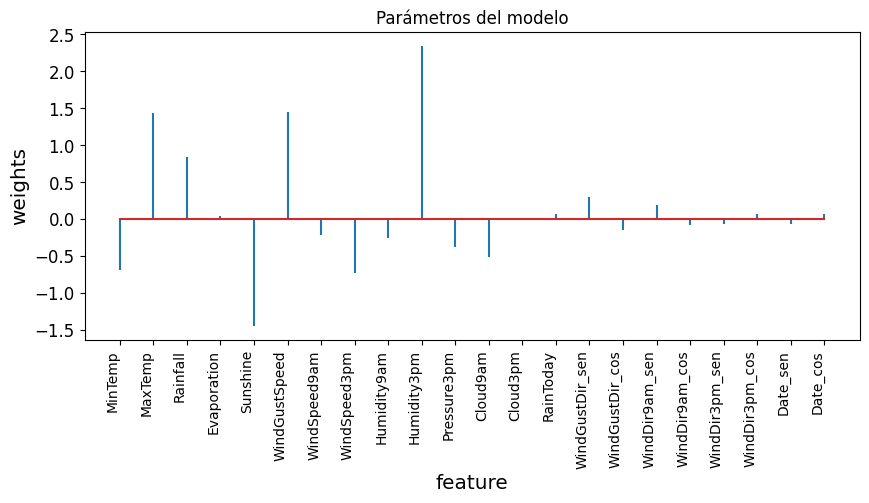

,predictor,coef
0,MinTemp,-0.685791
1,MaxTemp,1.436668
2,Rainfall,0.838359
3,Evaporation,0.036041
4,Sunshine,-1.447905
5,WindGustSpeed,1.443523
6,WindSpeed9am,-0.220621
7,WindSpeed3pm,-0.726146
8,Humidity9am,-0.260396
9,Humidity3pm,2.345417


In [244]:
# Se grafican los coeficientes del modelo
df_coeficientes = pd.DataFrame({'predictor': X_train.columns, 'coef': model.steps[1][1].coef_.flatten()})
fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()

df_coeficientes[df_coeficientes.coef != 0]

Se observa que las variables Humidity3pm, Sunshine, WindGustSpeed  y MaxTemp son las que mayor peso tienen en el modelo.

In [245]:
# Se guardan las predicciones del modelo
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)  # Asumiendo que tienes X_val e y_val

# Se calculan los errores RMSE
rmse_ols_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_ols_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_ols_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"RMSE train: {rmse_ols_train}")
print(f"RMSE validación: {rmse_ols_val}")
print(f"RMSE test: {rmse_ols_test}")

# Cálculo de R2
R2_ols_train = metrics.r2_score(y_train, y_pred_train)
R2_ols_test = metrics.r2_score(y_test, y_pred_test)
R2_ols_val = metrics.r2_score(y_val, y_pred_val)

print(f"\nR2 train: {R2_ols_train}")
print(f"R2 validación: {R2_ols_val}")
print(f"R2 test: {R2_ols_test}")

RMSE train: 6.010411602709435
RMSE validación: 6.0059088646140815
RMSE test: 6.193535317008064

R2 train: 0.2079401098519188
R2 validación: 0.23665899232548748
R2 test: 0.19555371980134095


Se observa un bajo valor de R2, lo que determina que el modelo no logra explicar correctamente la variabilidad de los datos.

#### Gradiente descendiente

In [246]:
# Se convierten dataframes a arrays
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# Escalado de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Se aplica el método del Gradiente Descendiente (GD), con sus variantes Gradiente Descendiente Estocástico (GDE) y Gradiente Descendiente Mini-Batch (GDB).
No se observan mejoras en los valores de RMSE y R2 obtenidos, en comparación con los de Regresión Lineal.

##### Gradiente Descendiente GD

In [247]:
def gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test, lr=0.01, epochs=100, seed=semilla):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = qxm
        y_val = qx1
        X_test = pxm
        y_test = px1
        W = mx1
    """

    # Obtener dimensiones de los datos
    n, m = X_train.shape
    q = X_val.shape[0]
    o = X_test.shape[0]

    # Agregar columna de unos (bias) a todos los conjuntos
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((q, 1)), X_val))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    # Inicializar pesos
    np.random.seed(seed)
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    # Listas para almacenar métricas
    train_errors = []
    val_errors = []
    test_errors = []

    for i in range(epochs):
        # Cálculo de predicciones para todos los conjuntos
        prediction_train = X_train @ W
        prediction_val = X_val @ W
        prediction_test = X_test @ W

        # Cálculo de errores
        error_train = y_train - prediction_train
        error_val = y_val - prediction_val
        error_test = y_test - prediction_test

        # Almacenar RMSEs
        train_rmse = np.sqrt(np.mean(error_train**2))
        val_rmse = np.sqrt(np.mean(error_val**2))
        test_rmse = np.sqrt(np.mean(error_test**2))

        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
        test_errors.append(test_rmse)

        # Actualización de pesos (solo con train)
        grad = (-2/n) * X_train.T @ error_train
        W -= lr * grad

    # Predicciones finales
    final_train_pred = np.matmul(X_train, W)
    final_val_pred = np.matmul(X_val, W)
    final_test_pred = np.matmul(X_test, W)

    # Métricas finales
    final_metrics = {
        'train_rmse': np.sqrt(np.mean((y_train - final_train_pred)**2)),
        'train_r2': r2_score(y_train, final_train_pred),
        'val_rmse': np.sqrt(np.mean((y_val - final_val_pred)**2)),
        'val_r2': r2_score(y_val, final_val_pred),
        'test_rmse': np.sqrt(np.mean((y_test - final_test_pred)**2)),
        'test_r2': r2_score(y_test, final_test_pred),
        'predictores': W
    }

    # Gráfico actualizado con validación
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Entrenamiento')
    plt.plot(val_errors, label='Validación', linestyle='--')
    plt.plot(test_errors, label='Test', linestyle=':')
    plt.xlabel('Época')
    plt.ylabel('RMSE')
    plt.title('Evolución de Errores (GD)')
    plt.legend()
    plt.show()

    return final_metrics

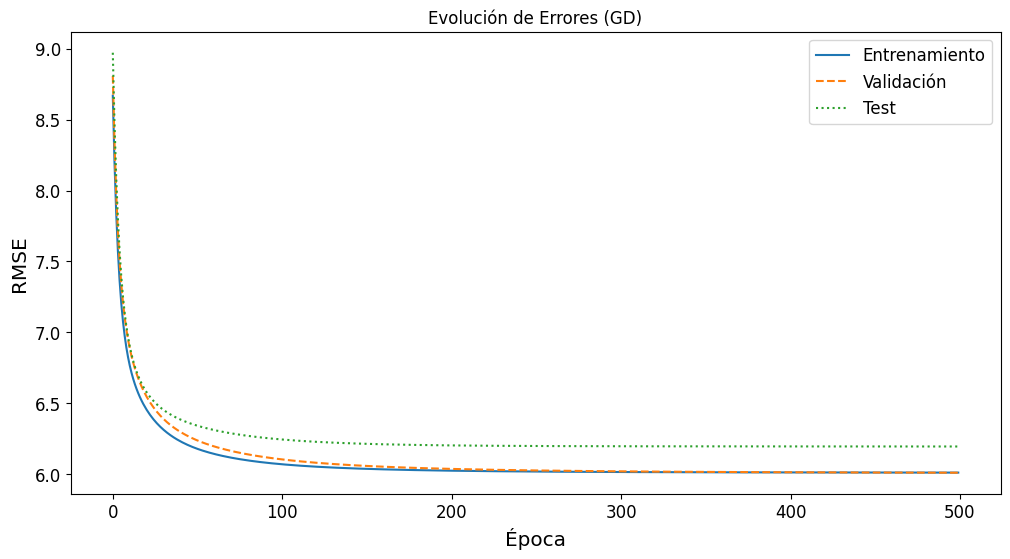


=== Métricas Gradiente Descendiente ===
- RMSE Train: 6.0114
- RMSE Validación: 6.0105
- RMSE Test: 6.1955

- R2 Train: 0.2077
- R2 Validación: 0.2355
- R2 Test: 0.1951


In [248]:
resultados_gd = gradient_descent(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    epochs=500,
    lr=0.02
)

# Extracción de métricas
rmse_gd_train = resultados_gd['train_rmse']
rmse_gd_val = resultados_gd['val_rmse']
rmse_gd_test = resultados_gd['test_rmse']
R2_gd_train = resultados_gd['train_r2']
R2_gd_val = resultados_gd['val_r2']
R2_gd_test = resultados_gd['test_r2']

print("\n=== Métricas Gradiente Descendiente ===")
print(f"- RMSE Train: {rmse_gd_train:.4f}")
print(f"- RMSE Validación: {rmse_gd_val:.4f}")
print(f"- RMSE Test: {rmse_gd_test:.4f}")
print(f"\n- R2 Train: {R2_gd_train:.4f}")
print(f"- R2 Validación: {R2_gd_val:.4f}")
print(f"- R2 Test: {R2_gd_test:.4f}")

##### Gradiente Descendiente Estocástico SGD

In [249]:
def stochastic_gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test,
                               lr=0.01, epochs=100, n_jobs=-1, seed=semilla):

    # Añadir columna de unos (bias) a las features
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_val = np.c_[np.ones(X_val.shape[0]), X_val]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    # Inicializar pesos como vector 1D (m+1,)
    np.random.seed(seed)
    W = np.random.randn(X_train.shape[1])

    # Listas para almacenar errores
    train_errors, val_errors, test_errors = [], [], []

    # Función de actualización de pesos
    def update_weights(x, y, weights, lr):
        prediction = np.dot(x, weights)
        error = y - prediction
        gradient = -2 * error * x
        new_weights = weights - (lr * gradient)
        return new_weights, error**2

    # Entrenamiento
    for _ in tqdm(range(epochs), desc='Entrenamiento SGD'):
        # Mezclar datos
        idx = np.random.permutation(X_train.shape[0])
        X_shuffled, y_shuffled = X_train[idx], y_train[idx]

        # Actualización paralela de pesos
        results = Parallel(n_jobs=n_jobs)(
            delayed(update_weights)(X_shuffled[i], y_shuffled[i], W, lr)
            for i in range(X_shuffled.shape[0])
        )

        # Promediar pesos y calcular errores
        weights_list, squared_errors = zip(*results)
        W = np.mean(weights_list, axis=0)  # Vector 1D (m+1,)
        train_rmse = np.sqrt(np.mean(squared_errors))
        train_errors.append(train_rmse)

        # Calcular errores en validación y test
        for X, y, errors in [(X_val, y_val, val_errors), (X_test, y_test, test_errors)]:
            pred = X.dot(W)  # Vector 1D (n,)
            errors.append(np.sqrt(mean_squared_error(y, pred)))

    # Métricas finales
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, X_train.dot(W))),
        'train_r2': r2_score(y_train, X_train.dot(W)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, X_val.dot(W))),
        'val_r2': r2_score(y_val, X_val.dot(W)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, X_test.dot(W))),
        'test_r2': r2_score(y_test, X_test.dot(W)),
        'weights': W
    }

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Entrenamiento')
    plt.plot(val_errors, label='Validación', linestyle='--')
    plt.plot(test_errors, label='Test', linestyle=':')
    plt.xlabel('Época')
    plt.ylabel('RMSE')
    plt.title('Evolución de Errores (SGD)')
    plt.legend()
    plt.show()

    return metrics

Entrenamiento SGD: 100%|██████████| 500/500 [10:23<00:00,  1.25s/it]


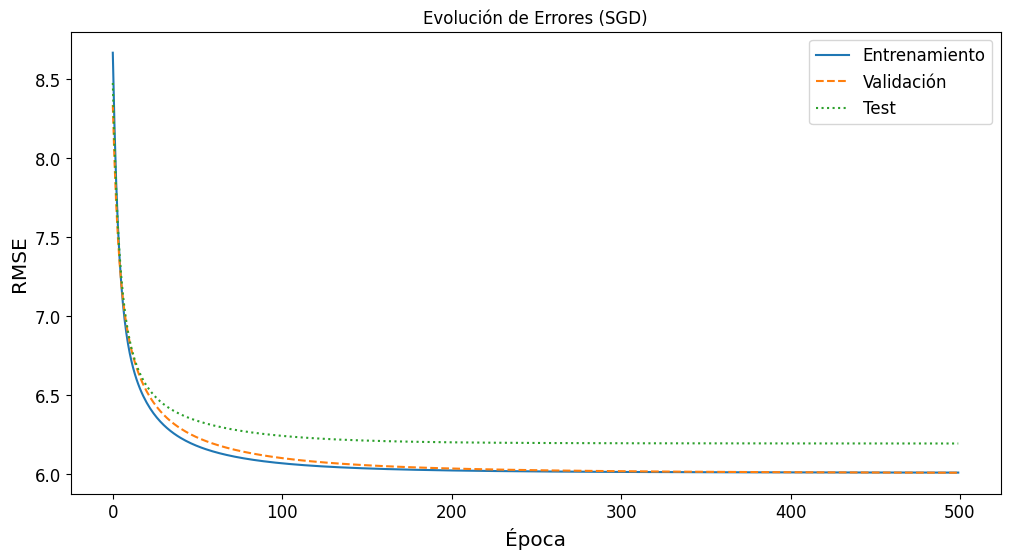


=== Métricas Gradiente Descendiente Estocástico ===
- RMSE Train: 6.0114
- RMSE Validación: 6.0105
- RMSE Test: 6.1955

- R2 Train: 0.2077
- R2 Validación: 0.2355
- R2 Test: 0.1951


In [250]:
resultados_sgd = stochastic_gradient_descent(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    lr=0.02,
    epochs=500
)


# Extracción de métricas
rmse_sgd_train = resultados_sgd['train_rmse']
rmse_sgd_val = resultados_sgd['val_rmse']
rmse_sgd_test = resultados_sgd['test_rmse']
R2_sgd_train = resultados_sgd['train_r2']
R2_sgd_val = resultados_sgd['val_r2']
R2_sgd_test = resultados_sgd['test_r2']

# Imprimir métricas
print("\n=== Métricas Gradiente Descendiente Estocástico ===")
print(f"- RMSE Train: {rmse_sgd_train:.4f}")
print(f"- RMSE Validación: {rmse_sgd_val:.4f}")
print(f"- RMSE Test: {rmse_sgd_test:.4f}")
print(f"\n- R2 Train: {R2_sgd_train:.4f}")
print(f"- R2 Validación: {R2_sgd_val:.4f}")
print(f"- R2 Test: {R2_sgd_test:.4f}")

##### Gradiente Descendiente Mini-Batch

In [251]:
# Aplanar los arrays y_train, y_val, y_test
y_train = y_train.ravel()  # Convierte (n,1) a (n,)
y_val = y_val.ravel()
y_test = y_test.ravel()

In [252]:
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, X_test, y_test,
                               lr=0.01, epochs=100, batch_size=32, seed=semilla):

    # Añadir columna de unos (bias)
    X_train = np.c_[np.ones(X_train.shape[0]), X_train]
    X_val = np.c_[np.ones(X_val.shape[0]), X_val]
    X_test = np.c_[np.ones(X_test.shape[0]), X_test]

    # Inicializar pesos
    np.random.seed(seed)
    W = np.random.randn(X_train.shape[1])

    # Almacenar errores
    train_errors, val_errors, test_errors = [], [], []

    for _ in tqdm(range(epochs), desc='Entrenamiento Mini-batch GD'):
        # Mezclar datos
        idx = np.random.permutation(X_train.shape[0])
        X_shuffled, y_shuffled = X_train[idx], y_train[idx]  # y_shuffled ya es 1D

        # Procesar por mini-lotes
        for i in range(0, X_shuffled.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]  # 1D (batch_size,)

            # Calcular predicción y error
            predictions = X_batch.dot(W)  # 1D (batch_size,)
            error = y_batch - predictions  # 1D - 1D = 1D

            # Calcular gradiente (vectorizado)
            gradient = -2 * X_batch.T.dot(error) / len(y_batch)  # (features+1,)

            # Actualizar pesos
            W -= lr * gradient  # Ambos son 1D

        # Calcular errores después de cada época
        for X, y, errors in [(X_train, y_train, train_errors),
                            (X_val, y_val, val_errors),
                            (X_test, y_test, test_errors)]:
            pred = X.dot(W)
            errors.append(np.sqrt(mean_squared_error(y, pred)))

    # Métricas
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, X_train.dot(W))),
        'train_r2': r2_score(y_train, X_train.dot(W)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, X_val.dot(W))),
        'val_r2': r2_score(y_val, X_val.dot(W)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, X_test.dot(W))),
        'test_r2': r2_score(y_test, X_test.dot(W)),
        'weights': W
    }

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Entrenamiento')
    plt.plot(val_errors, label='Validación', linestyle='--')
    plt.plot(test_errors, label='Test', linestyle=':')
    plt.xlabel('Época')
    plt.ylabel('RMSE')
    plt.title('Evolución de Errores (Mini-batch GD)')
    plt.legend()
    plt.show()

    return metrics

Entrenamiento Mini-batch GD: 100%|██████████| 400/400 [00:01<00:00, 305.94it/s]


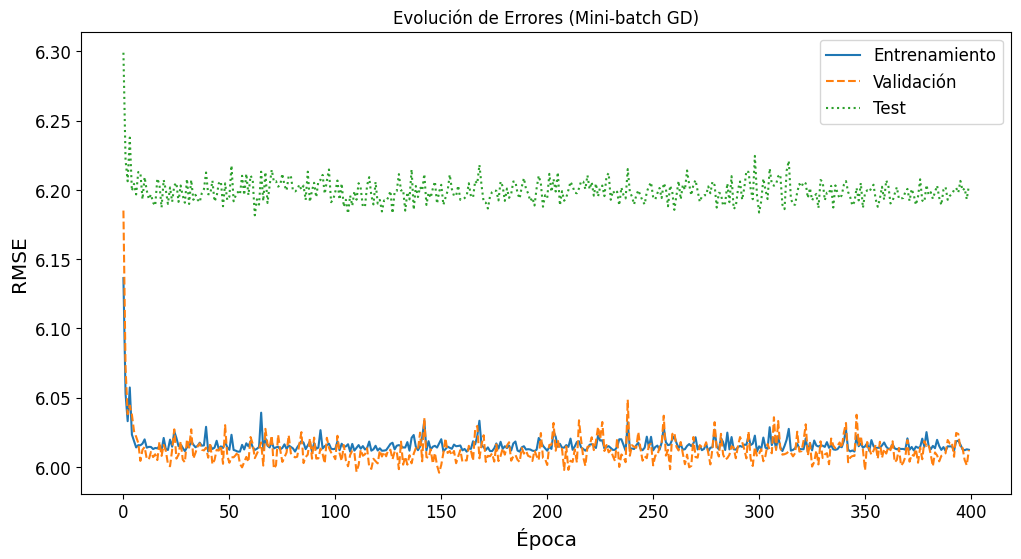


=== Métricas Gradiente Descendiente Mini-Batch ===
- RMSE Train: 6.0124
- RMSE Validación: 6.0123
- RMSE Test: 6.2031

- R2 Train: 0.2074
- R2 Validación: 0.2350
- R2 Test: 0.1931


In [253]:
resultados_mbgd = mini_batch_gradient_descent(
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    lr=0.01,
    epochs=400,
    batch_size=100)

# Extracción de métricas
rmse_mbgd_train = resultados_mbgd['train_rmse']
rmse_mbgd_val = resultados_mbgd['val_rmse']
rmse_mbgd_test = resultados_mbgd['test_rmse']
R2_mbgd_train = resultados_mbgd['train_r2']
R2_mbgd_val = resultados_mbgd['val_r2']
R2_mbgd_test = resultados_mbgd['test_r2']

print("\n=== Métricas Gradiente Descendiente Mini-Batch ===")
print(f"- RMSE Train: {rmse_mbgd_train:.4f}")
print(f"- RMSE Validación: {rmse_mbgd_val:.4f}")
print(f"- RMSE Test: {rmse_mbgd_test:.4f}")
print(f"\n- R2 Train: {R2_mbgd_train:.4f}")
print(f"- R2 Validación: {R2_mbgd_val:.4f}")
print(f"- R2 Test: {R2_mbgd_test:.4f}")

#### Lasso Regression

In [254]:
# Creación y entrenamiento del modelo
modelo = make_pipeline(
    StandardScaler(),  # Estandarización de los datos: media 0 y desviación estándar 1
    LassoCV(
        alphas=np.logspace(-10, 10, 200),  # Prueba 200 valores de alpha
        cv=10  # Validación cruzada de 10 folds
    )
)

# Entrenar el modelo con más datos
X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)
modelo.fit(X_train_full, y_train_full)

# Predicciones
y_train_full_pred = modelo.predict(X_train_full)
y_test_pred = modelo.predict(X_test)

# Métricas de evaluación
def calcular_metricas(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    return rmse, r2

# Calcular métricas
train_lassocv_rmse, train_lassocv_r2 = calcular_metricas(y_train_full, y_train_full_pred)
test_lassocv_rmse, test_lassocv_r2 = calcular_metricas(y_test, y_test_pred)

# Mostrar resultados
print(f"El mejor valor de alpha seleccionado es: {round(modelo.named_steps['lassocv'].alpha_, 6)}") # aproximadamente 10^(-2)
print("Métricas del modelo LassoCV:")
print(f"  - Entrenamiento: RMSE = {train_lassocv_rmse:.4f}, R2 = {train_lassocv_r2:.4f}")
print(f"  - Prueba:        RMSE = {test_lassocv_rmse:.4f}, R2 = {test_lassocv_r2:.4f}")

El mejor valor de alpha seleccionado es: 0.008704
Métricas del modelo LassoCV:
  - Entrenamiento: RMSE = 6.0078, R2 = 0.2136
  - Prueba:        RMSE = 6.1874, R2 = 0.1972


**Observación:** *¿Qué hace LassoCV?*

Al utilizar cv=10, el modelo divide internamente el conjunto de train en 10 folds para validación cruzada. Prueba todos los valores de alpha en cada combinación de 9 folds para entrenar y 1 fold para validar. Selecciona el mejor alpha basado en el promedio del error (RMSE) de los 10 folds.

Se concatenan `X_train` y `X_val` (y sus targets) para entrenar el modelo final, aprovechando la mayor cantidad de datos disponibles y mejorando su generalización. Las métricas reportadas en prueba reflejan el rendimiento en datos nunca utilizados durante el entrenamiento.

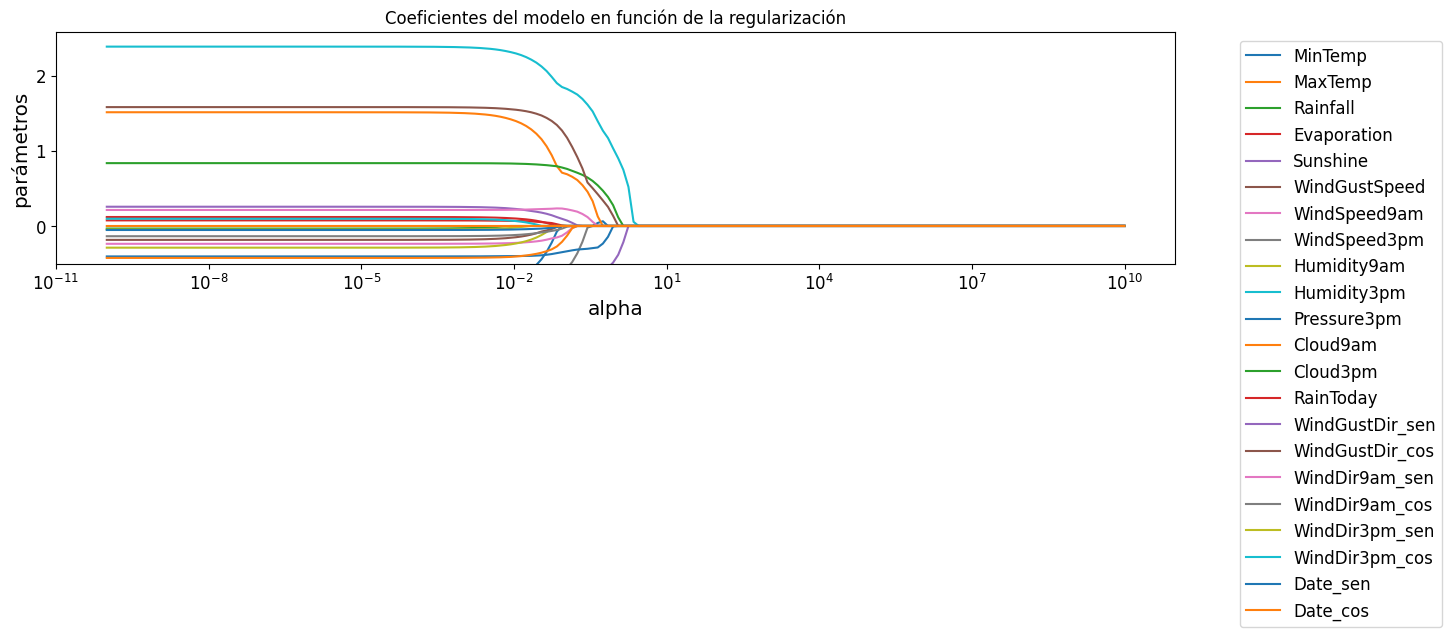

In [255]:
# Evolución de los parámetros en función de alpha
mod = modelo.named_steps['lassocv']
alphas = mod.alphas_

# Función para ajustar un modelo Lasso con un valor específico de alpha
def fit_lasso(alpha, X_train, y_train):
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    return modelo_aux.named_steps['lasso'].coef_.flatten()

# Paralelizar el ajuste de modelos para diferentes valores de alpha
coefs = Parallel(n_jobs=-1)(delayed(fit_lasso)(alpha, X_train_full, y_train_full) for alpha in alphas)

# Graficar la evolución de los coeficientes en función de alpha
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5, None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Leyenda fuera del gráfico
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.tight_layout()
plt.show()

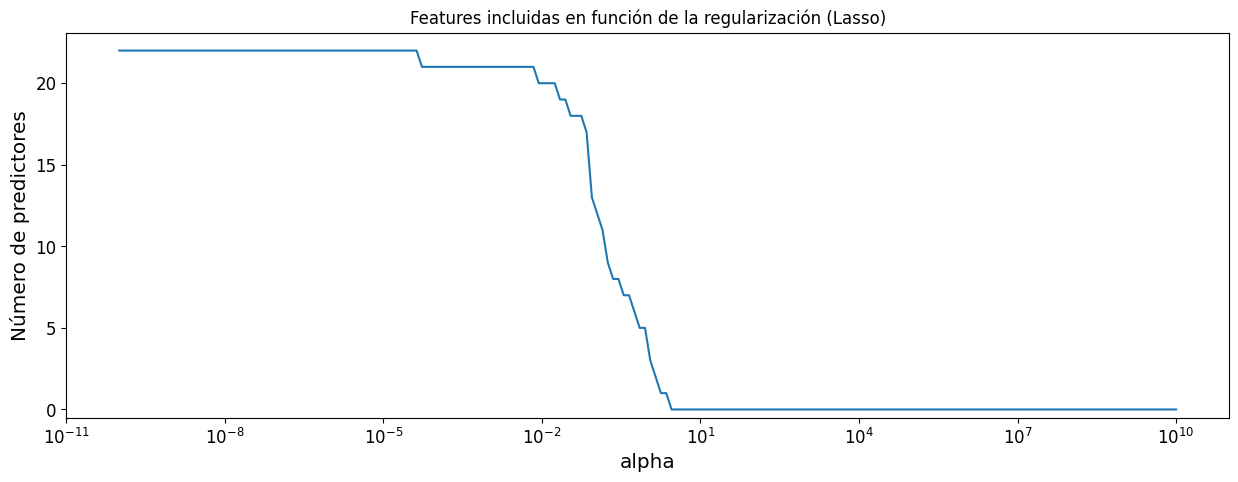

In [256]:
# Definir la función para contar coeficientes no nulos
def count_non_zero_coefs(alpha, X_train, y_train):
    """
    Ajusta un modelo Lasso con un valor específico de alpha y cuenta los coeficientes no nulos.
    """
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.named_steps['lasso'].coef_.flatten() != 0)
    return coef_no_cero

# Obtener los valores de alpha usados en LassoCV
alphas = modelo.named_steps['lassocv'].alphas_

# Paralelizar el cálculo del número de predictores no nulos para cada alpha
n_predictores = Parallel(n_jobs=-1)(delayed(count_non_zero_coefs)(alpha, X_train_full, y_train_full) for alpha in alphas)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')  # Escala logarítmica para el eje x (alpha)
ax.set_ylim([-0.5, None])
ax.set_xlabel('alpha')
ax.set_ylabel('Número de predictores')
ax.set_title('Features incluidas en función de la regularización (Lasso)')
plt.show()

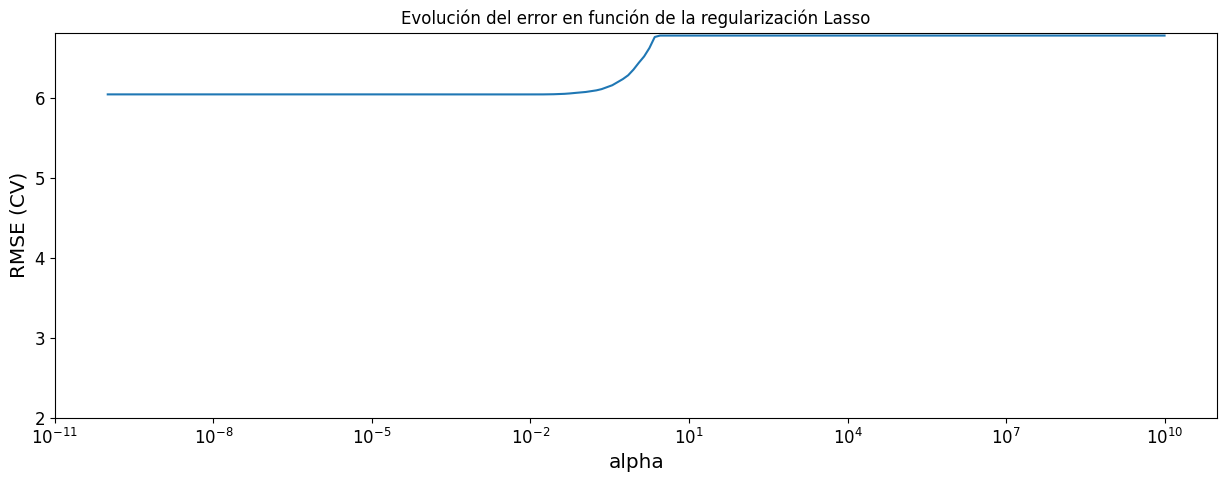

Alpha óptimo: 0.008704
RMSE mínimo (Validación Cruzada): 6.0425


In [257]:
# Calcular el RMSE de validación cruzada (promedio de los folds)
rmse_cv = np.sqrt(mod.mse_path_.mean(axis=1))  # Convertir MSE a RMSE

# Identificar el mejor alpha (el que minimiza el RMSE)
min_rmse = np.min(rmse_cv)  # Menor RMSE
optimo = mod.alphas_[np.argmin(rmse_cv)]  # Alpha óptimo

# Graficar la evolución del RMSE en función de alpha

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización Lasso')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE (CV)')
plt.show()

# Mostrar el valor óptimo de alpha y el RMSE mínimo
print(f"Alpha óptimo: {optimo:.6f}")
print(f"RMSE mínimo (Validación Cruzada): {min_rmse:.4f}")

**Observación:** El valor mínimo obtenido de RMSE (6.0425) en cross validation, difiere del RMSE obtenido al evaluar el modelo en el conjunto de train, ya que una vez hallado alpha óptimo, Lasso CV reentrena utilizando todos los datos de train con dicho alpha. Obteniendo así una mejor performance (6.0078).

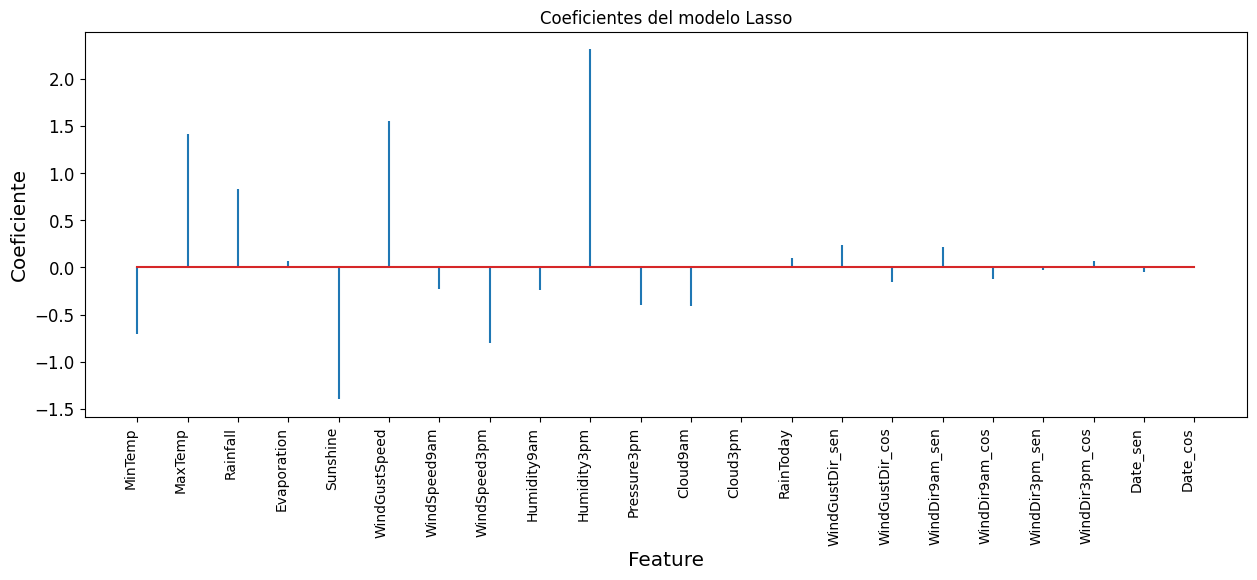

Coeficientes no nulos:
          predictor      coef
0           MinTemp -0.708239
1           MaxTemp  1.417345
2          Rainfall  0.830488
3       Evaporation  0.067993
4          Sunshine -1.399093
5     WindGustSpeed  1.552170
6      WindSpeed9am -0.227827
7      WindSpeed3pm -0.804514
8       Humidity9am -0.243847
9       Humidity3pm  2.311099
10      Pressure3pm -0.400609
11         Cloud9am -0.410957
13        RainToday  0.102887
14  WindGustDir_sen  0.232297
15  WindGustDir_cos -0.156819
16   WindDir9am_sen  0.215065
17   WindDir9am_cos -0.123296
18   WindDir3pm_sen -0.026617
19   WindDir3pm_cos  0.071697
20         Date_sen -0.047659


In [258]:
# Crear un DataFrame con los coeficientes del modelo
df_coeficientes = pd.DataFrame({
    'predictor': X_train.columns,  # Nombres de las características
    'coef': mod.coef_.flatten()    # Coeficientes del modelo Lasso
})

# Graficar los coeficientes
fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)  # Rotar etiquetas del eje x
ax.set_xlabel('Feature')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes del modelo Lasso')
plt.show()

# Filtrar coeficientes no nulos
coeficientes_no_nulos = df_coeficientes[df_coeficientes.coef != 0]
print("Coeficientes no nulos:")
print(coeficientes_no_nulos)

#### Ridge Regression

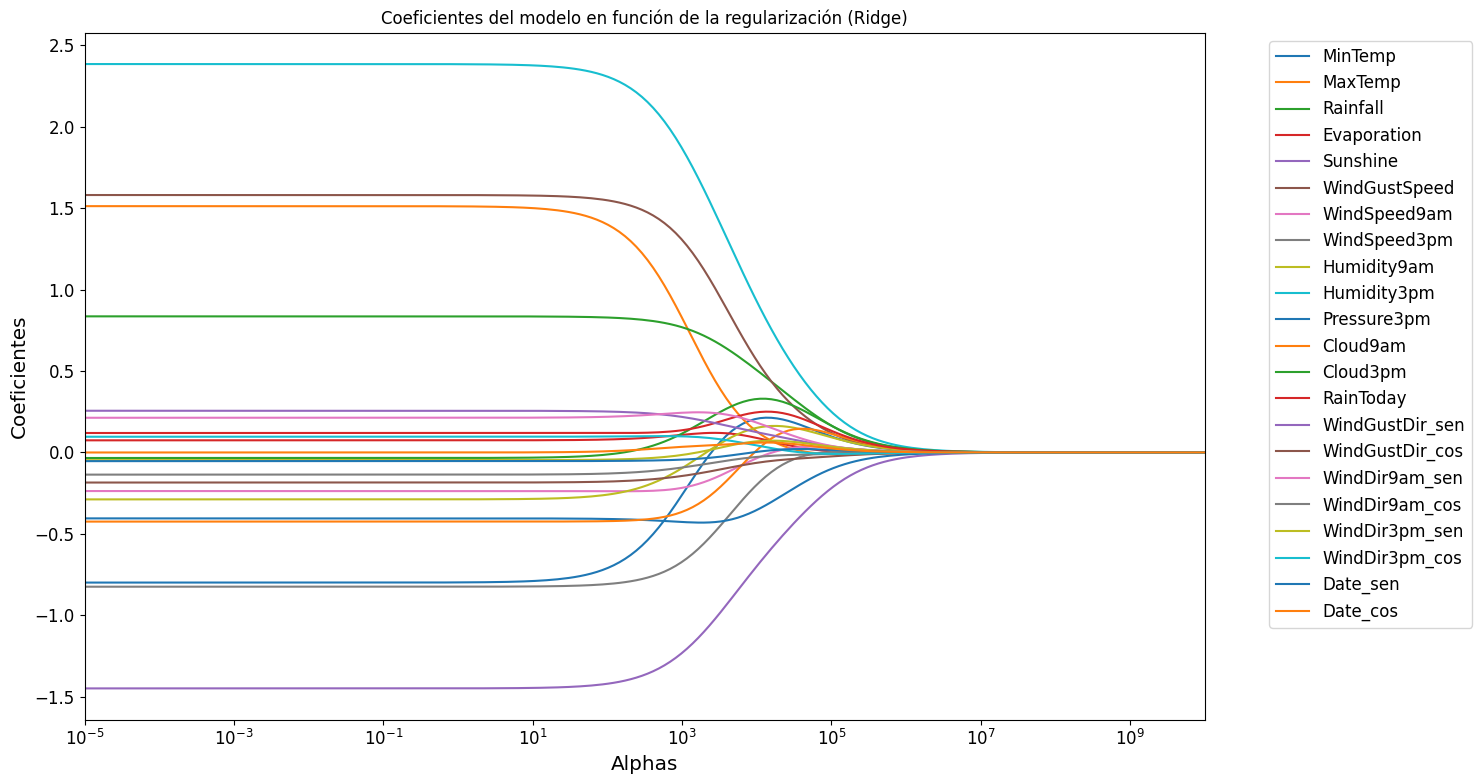

In [259]:
# Generar valores de alpha desde 10^-5 hasta 10^10
alphas = np.logspace(-5, 10, 200)

# Crear el modelo RidgeCV con los alphas definidos
modelo = make_pipeline(
    StandardScaler(), # Estandarización de los datos: media 0 y desviación estándar 1
    RidgeCV(alphas=alphas, cv=10)
)

# Entrenar el modelo
modelo.fit(X_train_full, y_train_full)

# Obtener los alphas usados (son los mismos que se pasaron)
alphas_used = modelo.named_steps['ridgecv'].alphas
coefs = []

# Ajustar modelos para cada alpha y guardar coeficientes
for alpha in alphas_used:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train_full, y_train_full)
    coefs.append(modelo_aux.named_steps['ridge'].coef_.flatten())

# Graficar
fig, ax = plt.subplots(figsize=(15, 8))
for i, col in enumerate(X_train.columns):
    ax.plot(alphas_used, [coef[i] for coef in coefs], label=col)

# Configurar ejes para cubrir hasta 10^10
ax.set_xscale('log')
ax.set_xlim([1e-5, 1e10]) # Límites manuales del eje x
ax.set_xlabel('Alphas')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización (Ridge)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [260]:
# Predicciones
y_train_full_pred = modelo.predict(X_train_full)
y_test_pred = modelo.predict(X_test)

# Métricas de evaluación
def calcular_metricas(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    return rmse, r2

# Calcular métricas
train_ridgecv_rmse, train_ridgecv_r2 = calcular_metricas(y_train_full, y_train_full_pred)
test_ridgecv_rmse, test_ridgecv_r2 = calcular_metricas(y_test, y_test_pred)

# Mostrar resultados
print(f"El mejor valor de alpha seleccionado es: {round(modelo.named_steps['ridgecv'].alpha_, 6)}") # aproximadamente 10^(-2)
print("Métricas del modelo RidgeCV:")
print(f"  - Entrenamiento: RMSE = {train_ridgecv_rmse:.4f}, R2 = {train_ridgecv_r2:.4f}")
print(f"  - Prueba:        RMSE = {test_ridgecv_rmse:.4f}, R² = {test_ridgecv_r2:.4f}")

El mejor valor de alpha seleccionado es: 243.744415
Métricas del modelo RidgeCV:
  - Entrenamiento: RMSE = 6.0088, R2 = 0.2134
  - Prueba:        RMSE = 6.1905, R² = 0.1963


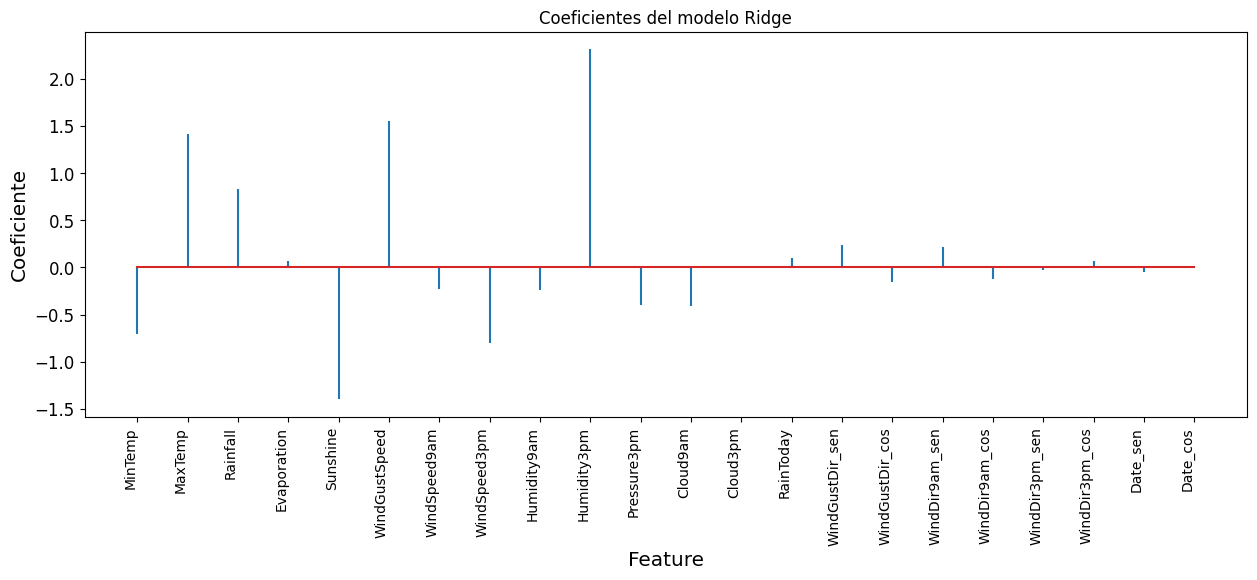

Coeficientes no nulos:
          predictor      coef
0           MinTemp -0.708239
1           MaxTemp  1.417345
2          Rainfall  0.830488
3       Evaporation  0.067993
4          Sunshine -1.399093
5     WindGustSpeed  1.552170
6      WindSpeed9am -0.227827
7      WindSpeed3pm -0.804514
8       Humidity9am -0.243847
9       Humidity3pm  2.311099
10      Pressure3pm -0.400609
11         Cloud9am -0.410957
13        RainToday  0.102887
14  WindGustDir_sen  0.232297
15  WindGustDir_cos -0.156819
16   WindDir9am_sen  0.215065
17   WindDir9am_cos -0.123296
18   WindDir3pm_sen -0.026617
19   WindDir3pm_cos  0.071697
20         Date_sen -0.047659


In [261]:
# Crear un DataFrame con los coeficientes del modelo
df_coeficientes = pd.DataFrame({
    'predictor': X_train.columns,  # Nombres de las características
    'coef': mod.coef_.flatten()    # Coeficientes del modelo Lasso
})

# Graficar los coeficientes
fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)  # Rotar etiquetas del eje x
ax.set_xlabel('Feature')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes del modelo Ridge')
plt.show()

# Filtrar coeficientes no nulos
coeficientes_no_nulos = df_coeficientes[df_coeficientes.coef != 0]
print("Coeficientes no nulos:")
print(coeficientes_no_nulos)

#### ElasticNet

Nota: l1_ratio es un parámetro en el modelo de regresión ElasticNet que controla la proporción entre la penalización L1 (norma Lasso) y la penalización L2 (norma Ridge). Cuando l1_ratio es 0, ElasticNet se comporta como una regresión Ridge, y cuando l1_ratio es 1, se comporta como una regresión Lasso.

In [262]:
# Creación y entrenamiento del modelo
modelo = make_pipeline(
    StandardScaler(),  # Estandarización de los datos
    ElasticNetCV(
        l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],  # Rangos de mezcla L1/L2
        alphas=np.logspace(-10, 10, 200),  # 200 valores de regularización
        cv=10
    )
)

# Entrenar el modelo
modelo.fit(X_train_full, y_train_full)

# Obtener el modelo entrenado
mod = modelo.named_steps['elasticnetcv']

# Mejores parámetros encontrados
print("═"*50)
print(f"Mejor valor de alpha encontrado: {mod.alpha_:.6f}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_:.4f}")
print("═"*50)

# Predicciones
y_train_full_pred = modelo.predict(X_train_full)
y_test_pred = modelo.predict(X_test)

# Función para cálculo de métricas
def calcular_metricas(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    return rmse, r2

# Cálculo de métricas
train_elasticnetcv_rmse, train_elasticnetcv_r2 = calcular_metricas(y_train_full, y_train_full_pred)
test_elasticnetcv_rmse, test_elasticnetcv_r2 = calcular_metricas(y_test, y_test_pred)

# Resultados
print("═"*50)
print("Métricas del modelo ElasticNetCV:")
print(f"  - Entrenamiento: RMSE = {train_elasticnetcv_rmse:.4f} | R2 = {train_elasticnetcv_r2:.4f}")
print(f"  - Prueba:        RMSE = {test_elasticnetcv_rmse:.4f} | R2 = {test_elasticnetcv_r2:.4f}")
print("═"*50)

══════════════════════════════════════════════════
Mejor valor de alpha encontrado: 0.008704
Mejor valor de l1_ratio encontrado: 0.9900
══════════════════════════════════════════════════
══════════════════════════════════════════════════
Métricas del modelo ElasticNetCV:
  - Entrenamiento: RMSE = 6.0078 | R2 = 0.2136
  - Prueba:        RMSE = 6.1874 | R2 = 0.1972
══════════════════════════════════════════════════


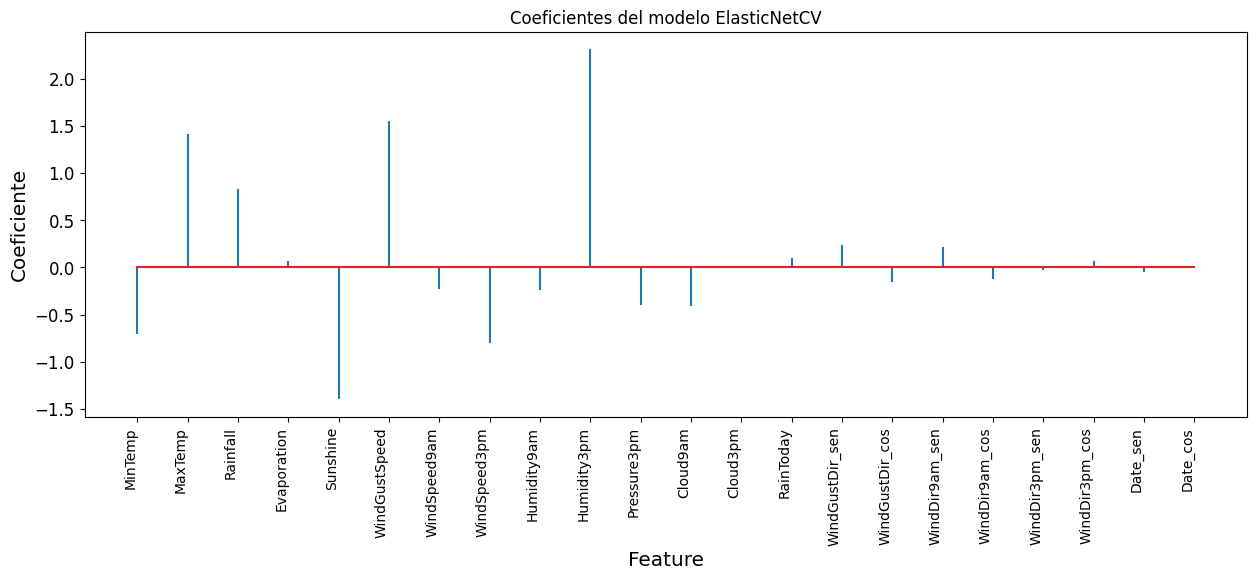

Características relevantes (coeficientes != 0):
          predictor      coef
0           MinTemp -0.707960
1           MaxTemp  1.416834
2          Rainfall  0.830443
3       Evaporation  0.068152
4          Sunshine -1.399167
5     WindGustSpeed  1.552012
6      WindSpeed9am -0.227943
7      WindSpeed3pm -0.804491
8       Humidity9am -0.243912
9       Humidity3pm  2.310811
10      Pressure3pm -0.400709
11         Cloud9am -0.411054
13        RainToday  0.103054
14  WindGustDir_sen  0.232482
15  WindGustDir_cos -0.157034
16   WindDir9am_sen  0.215127
17   WindDir9am_cos -0.123350
18   WindDir3pm_sen -0.026784
19   WindDir3pm_cos  0.071966
20         Date_sen -0.047715


In [263]:
# Coeficientes del modelo ElasticNetCV
df_coeficientes = pd.DataFrame({
    'predictor': X_train.columns, # Nombres de las características
    'coef': mod.coef_.flatten()  # Acceder a los coeficientes del modelo
})

# Gráfico de coeficientes
fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('Feature')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes del modelo ElasticNetCV')
#plt.tight_layout()
plt.show()

print("Características relevantes (coeficientes != 0):")
coeficientes_no_nulos = df_coeficientes[df_coeficientes.coef != 0]
print(coeficientes_no_nulos)

#### Resumen: Modelos de Regresión

Se confecciona una tabla comparativa con los distintos modelos aplicados.

In [264]:
df_comparacion_reg = pd.DataFrame({
    'Modelo': ['OLS', 'GD', 'SGD', 'GDMB', 'Ridge', 'Lasso', 'Elastic-net'],

    'Train RMSE': [rmse_ols_train, rmse_gd_train, rmse_sgd_train, rmse_mbgd_train, train_lassocv_rmse, train_ridgecv_rmse, train_elasticnetcv_rmse],
    'Val RMSE': [rmse_ols_val, rmse_gd_val, rmse_sgd_val, rmse_mbgd_val, np.nan, np.nan, np.nan],
    'Test RMSE': [rmse_ols_test, rmse_gd_test, rmse_sgd_test, rmse_mbgd_test, test_lassocv_rmse, test_ridgecv_rmse, test_elasticnetcv_rmse],

    'Train R2': [R2_ols_train, R2_gd_train, R2_sgd_train, R2_mbgd_train, train_lassocv_r2, train_ridgecv_r2, train_elasticnetcv_r2],
    'Val R2': [R2_ols_val, R2_gd_val, R2_sgd_val, R2_mbgd_val, np.nan, np.nan, np.nan],
    'Test R2': [R2_ols_test, R2_gd_test, R2_sgd_test, R2_mbgd_test, test_lassocv_r2, test_ridgecv_r2, test_elasticnetcv_r2]
})

# Mostrar el DataFrame
df_comparacion_reg

,Modelo,Train RMSE,Val RMSE,Test RMSE,Train R2,Val R2,Test R2
0,OLS,6.010412,6.005909,6.193535,0.207940,0.236659,0.195554
1,GD,6.011354,6.010504,6.195455,0.207692,0.235491,0.195055
2,SGD,6.011354,6.010504,6.195455,0.207692,0.235491,0.195055
3,GDMB,6.012450,6.012347,6.203139,0.207403,0.235022,0.193057
4,Ridge,6.007773,NaN,6.187358,0.213638,NaN,0.197158
5,Lasso,6.008794,NaN,6.190489,0.213371,NaN,0.196345
6,Elastic-net,6.007772,NaN,6.187378,0.213638,NaN,0.197152


**Insights obtenidos**

**Rendimiento general en datos no vistos:**

Ridge tiene el mejor RMSE en test (6.187), seguido por Elastic-Net.
Estos son los modelos que generalizan *ligeramente* mejor.

R2 en test es consistentemente bajo (~0.193–0.197) para todos los modelos, indicando que ningún modelo captura significativamente la varianza de los datos. Esto podría deberse a un subajuste (underfitting) por limitaciones del modelo lineal.

**Sobreajuste (Overfitting):**

La regularización (Ridge, Lasso, Elastic-net) no reduce *drásticamente* el error en test, lo que indica que el modelo lineal básico (OLS) ya es suficientemente simple para estos datos.

**Validación Cruzada vs Conjunto de Validación:**

Ridge, Lasso y Elastic-net no tienen métricas de validación porque usan validación cruzada interna (CV). El conjunto de validación original se fusionó con el de entrenamiento para maximizar los datos disponibles.

Aún no se hizo uso del conjunto de validación para la optimización de hiperparámetros. Sí se corrieron modelos aplicando regularización con cross validation y la mejora fue mínima.

**Limitaciones:**

Los modelos explican sólo ~20% de la varianza, lo que indica que el problema puede requerir enfoques no lineales o más variables predictoras.

### 2.Modelos de Regresión Logística

In [265]:
df_train = pd.concat([df_train, df_val], axis=0)

In [266]:
#df_train.shape #(15171, 24)
#df_test.shape #(2677, 24)

Como se vio anteriormente existe un desbalance entre las clases RainTomorrow=True (llueve) y RainTomorrow=False (no llueve).

In [267]:
# Contar el número de ocurrencias de cada categoría en la columna 'RainTomorrow'
conteo_categorias = df_train['RainTomorrow'].value_counts() # False 11800 vs. True 3371

# Calcular la proporción de cada categoría
proporcion_no = round(conteo_categorias[0] / len(df_train), 2)
proporcion_yes = round(conteo_categorias[1] / len(df_train), 2)
print("Proporción de 'RainTomorrow' igual a 0 (No):", proporcion_no)
print("Proporción de 'RainTomorrow' igual a 1 (Yes):", proporcion_yes)

Proporción de 'RainTomorrow' igual a 0 (No): 0.78
Proporción de 'RainTomorrow' igual a 1 (Yes): 0.22


Se observa que para el conjunto de test, el valor rtest es similiar a rtrain, lo cual es un buen indicador de que el desbalance de las clases se mantiene en la misma proporción.
Si bien no se deberían ver los valores del conjunto de test, es una buena práctica hacer este chequeo para no incurrir en errores de predicción.

In [268]:
conteo_categorias = df_train['RainTomorrow'].value_counts()
rtrain=conteo_categorias[0] /conteo_categorias[1]
print("Relación entre clases rtrain:", rtrain)

Relación entre clases rtrain: 3.5004449718184514


In [269]:
conteo_categorias = df_test['RainTomorrow'].value_counts()
rtest=conteo_categorias[0] /conteo_categorias[1]
print("Relación entre clases rtest:", rtest)

Relación entre clases rtest: 3.2357594936708862


Se entrenan modelos de regresión logística (previa estandarización de los datos) y se imprimen las matrices de confusión.

Accuracy no será tenida en cuenta ya que no presenta buenos resultados ante conjuntos de datos con clases desbalanceadas.

Convenciones:
* Caso positivo significa que llueve
* Orden de los valores en la matriz de confusión: [[TN , FN] , [FP , TP]]


In [270]:
def matriz_conf (y_test,y_pred):
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, cmap="Blues", fmt="d", xticklabels=["No llueve", "Llueve"], yticklabels=["No llueve", "Llueve"]).set(title='Matriz de Confusión', xlabel='Valores reales', ylabel='Valores predichos')
    return plt.show()

Se crean los conjuntos de datos para entrenamiento y testeo:
* X_train
* y_train
* X_test
* y_test

**Nota:** Las soluciones que se explorarán en adelante no contemplarán conjunto de validación, por una cuestión de escasez de tiempos.  

In [ ]:
# Nueva función split que pisa la anterior  
def split(df_train, df_test, metodo='clasificacion'):
    if metodo == 'regresion':
        # Conjuntos de entrenamiento
        X_train = df_train.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_train = df_train[['RainfallTomorrow']]

        # Conjunto de test
        X_test = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_test = df_test[['RainfallTomorrow']]

    elif metodo == 'clasificacion':
        # Conjuntos de entrenamiento
        X_train = df_train.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_train = df_train[['RainTomorrow']]

        # Conjunto de test
        X_test = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
        y_test = df_test[['RainTomorrow']]

    return X_train, y_train, X_test, y_test

In [272]:
X_train, y_train, X_test, y_test = split(df_train, df_test)

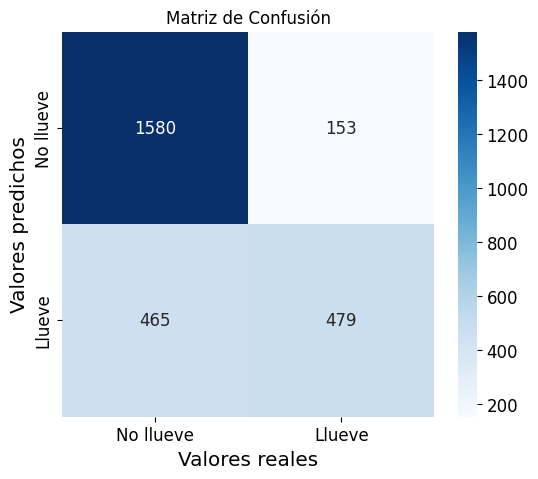


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.84      2045
         1.0       0.51      0.76      0.61       632

    accuracy                           0.77      2677
   macro avg       0.71      0.77      0.72      2677
weighted avg       0.82      0.77      0.78      2677



In [273]:
# Define el modelo de regresión logística
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=semilla, class_weight='balanced') # por defecto usa penalty=l2
)

# Entrenamiento del modelo
logreg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = logreg.predict(X_test)

# Mostrar la matriz de confusión
conf_matrix = matriz_conf(y_test, y_pred)

# Mostrar reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

De los días que no llovió, el modelo identifica correctamente el 77% de los casos. De forma similar, identifica correctamente el 76% de los días que llovió.

Se prueba otro modelo utilizando para el entrenamiento un conjunto oversampleado, lo que quiere decir que se incrementa el número de registros de la clase minoritaria para balancear el conjunto de datos de entrenamiento.

In [274]:
# Aplicar oversampling al conjunto de entrenamiento
oversampler = RandomOverSampler(random_state=semilla)
X_train_ovs, y_train_ovs = oversampler.fit_resample(X_train, y_train)

In [275]:
# Antes del oversampleo tenía 11800 False vs. 3371 True
# Verificar la distribución de clases en y_train
print("Distribución de clases después del oversampling:")
print(np.unique(y_train_ovs, return_counts=True))

# Verificar las dimensiones de X_train
print("\nDimensiones de X_train después del oversampling:")
print(X_train_ovs.shape)

Distribución de clases después del oversampling:
(array([False,  True]), array([11800, 11800], dtype=int64))

Dimensiones de X_train después del oversampling:
(23600, 22)


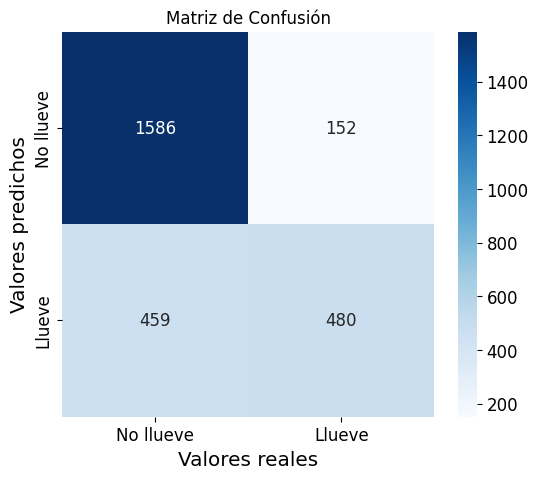


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      2045
         1.0       0.51      0.76      0.61       632

    accuracy                           0.77      2677
   macro avg       0.71      0.77      0.72      2677
weighted avg       0.82      0.77      0.78      2677



In [276]:
# Define el modelo de regresión logística
logreg_ovs = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=semilla)
)

# Entrenamiento del modelo
logreg_ovs.fit(X_train_ovs, y_train_ovs)

# Realizar predicciones en el conjunto de prueba
y_pred = logreg_ovs.predict(X_test)

# Mostrar la matriz de confusión
conf_matrix = matriz_conf(y_test, y_pred)

# Mostrar reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Se observa una mejora marginal, al aumentar TP en 1 y TN en 6. Las métricas no varían en comparación con el modelo anterior que utiliza la ponderación de clases.

#### Optimización del umbral

Se selecciona el modelo de regresión logística logreg_ovs con oversampling para la clase minoritaria para continuar con el análisis de optimización de umbral.

**Hasta aquí el entrenamiento de los modelos fue con un valor de umbral por defecto de 0.5.**

Se grafica la curva ROC para el modelo logreg_ovs.

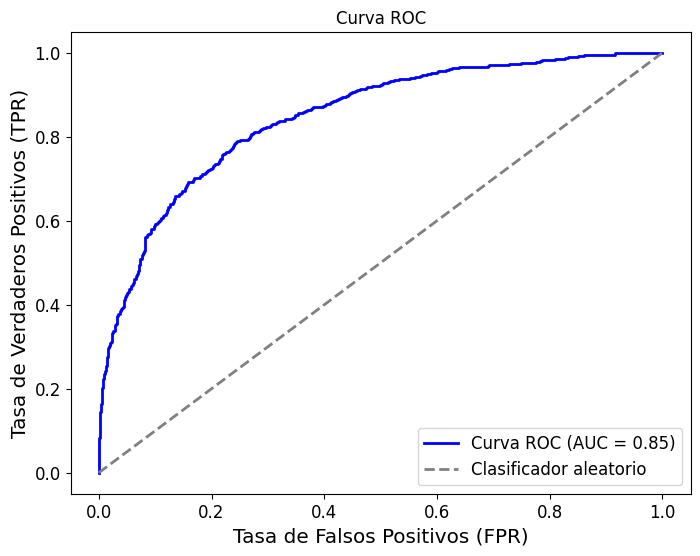

In [277]:
# Obtener las probabilidades de predicción para la clase positiva
y_pred_proba = logreg_ovs.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Se utiliza la curva ROC para identificar un valor de umbral que permita una combinación de valores para TPR y FPR más adecuada.

TPR utilizado: 0.8006329113924051
Umbral elegido: 0.44301487620164676


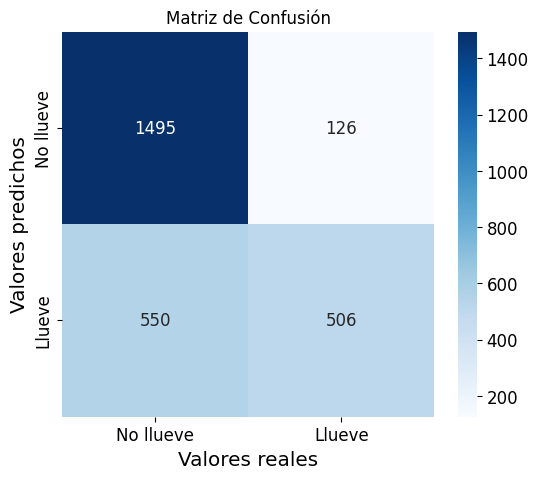


Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.82      2045
         1.0       0.48      0.80      0.60       632

    accuracy                           0.75      2677
   macro avg       0.70      0.77      0.71      2677
weighted avg       0.82      0.75      0.76      2677



In [ ]:
y_pred_proba = logreg_ovs.predict_proba(X_test)[:, 1]
fpr, tpr, umbral = roc_curve(y_test, y_pred_proba)
# se define este target luego de probar múltiples opciones (0.8 supera el tpr del modelo anterior: 0.76)
target_tpr = 0.8 

# Buscamos el índice del valor más cercano a target_tpr en el array de TPR
index = np.argmax(tpr >= target_tpr)
umbral_asociado = umbral[index]
fpr_asociado = fpr[index]
tpr_asociado = tpr[index]
print("TPR utilizado:", tpr_asociado)
print("Umbral elegido:", umbral_asociado)

#Se utiliza el umbral calculado para obtener las nuevas predicciones:
y_pred = (y_pred_proba >= umbral_asociado).astype(int)

# Mostrar la matriz de confusión
conf_matrix = matriz_conf(y_test, y_pred)

# Mostrar reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

#### Resumen: Modelos de Clasificación

Se confeccciona una tabla comparativa con los distintos modelos aplicados.

In [279]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_logreg = pd.DataFrame({
    'Modelo': ['LogReg_Balanceado', 'LogReg_OverSamp', 'LogReg_OverSamp_Umbral'],
    'Umbral': [0.5, 0.5, umbral_asociado],
    'TPR': ['0.759', '0.759', '0.8']
})

# Mostrar el DataFrame
df_comparacion_logreg

,Modelo,Umbral,TPR
0,LogReg_Balanceado,0.500000,0.759
1,LogReg_OverSamp,0.500000,0.759
2,LogReg_OverSamp_Umbral,0.443015,0.8


**Insights obtenidos**

El objetivo es predecir correctamente los días de lluvia, por eso se elige el modelo con umbral optimizado. Este último permite al modelo incrementar la detección correcta de días lluviosos a costa de una mayor tasa de falsos positivos.

El supuesto base es que es más caro que llueva y no estar preparados, versus a estar preparados y que no llueva.

### 3.Redes neuronales

#### Entrenamiento de modelos para Clasificación y Regresión

Se entrenan redes neuronales para resolver los problemas de regresión y clasificación. Se definen previamente las siguientes funciones:

In [280]:
# Función para la fijación de la semilla
def set_seed(seed=semilla):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [ ]:
#Calcula el mínimo valor de recall entre las clases

def recall_min(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.round(y_pred)
    y_pred = tf.cast(y_pred, tf.int32)

    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)

    unique_labels, _, unique_count = tf.unique_with_counts(y_true)

    def class_recall(cls):
        cls_true = tf.cast(tf.equal(y_true, cls), tf.float32)
        cls_pred = tf.cast(tf.equal(y_pred, cls), tf.float32)
        recall = tf.reduce_sum(cls_true * cls_pred) / (tf.reduce_sum(cls_true) + tf.keras.backend.epsilon())
        return recall

    recalls = tf.map_fn(class_recall, unique_labels, dtype=tf.float32)
    min_recall = tf.reduce_min(recalls)
    return min_recall

In [282]:
# Crear y entrenar el modelo final con los mejores hiperparámetros
def create_best_model(best_params, metodo='clasificacion'):
    num_layers = best_params['num_layers']
    epochs = best_params['epochs']
    batch_size = best_params['batch_size']
    optimizer = best_params.get('optimizer', 'adam')

    if metodo == 'clasificacion':
        loss = BinaryCrossentropy()
        metrics = [recall_min]
        output_units = best_params.get('output_units', 1)
        output_activation = 'sigmoid'
    elif metodo == 'regresion':
        loss = MeanSquaredError()
        metrics = [MSE()]
        output_units = best_params.get('output_units', 1)
        output_activation = 'linear'
    else:
        raise ValueError("problem_type debe ser 'clasificacion' o 'regresion'")

    model = Sequential()
    for i in range(num_layers):
        num_units = best_params[f'n_units_layer_{i}']
        dropout_rate = best_params[f'dropout_rate_layer_{i}']
        model.add(Dense(num_units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(output_units, activation=output_activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model, epochs, batch_size

In [283]:
# Función general para el entrenamiento de redes neuronales
def nn_model(X_train, y_train, X_test, y_test, metodo='clasificacion'):
    set_seed(50)

    if metodo=='clasificacion':
        direccion='maximize'
    elif metodo=='regresion':
        direccion='minimize'

    # Crear un estudio de Optuna
    study = optuna.create_study(direction=direccion, sampler=optuna.samplers.TPESampler(seed=50))
    if metodo == 'clasificacion':
        study.optimize(objective_clasificador, n_trials=10)
    elif metodo == 'regresion':
        study.optimize(objective_regresor, n_trials=10)
    # Obtener los mejores hiperparámetros
    best_params = study.best_params

    # Crear y entrenar el modelo final
    best_model, best_epochs, best_batch_size = create_best_model(best_params,metodo)
    best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=best_epochs, batch_size=best_batch_size, verbose=1)

    return best_model, study

La optimización de hiperparámetros se realiza con Optuna. Este método se elige por sobre Grid Search y Random Search por ser el más eficiente de los tres.

#### Resolución del problema de Clasificación

In [284]:
def objective_clasificador(trial):
    set_seed()
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 10, 100) # la cantidad de neuronas de cada capa tambien se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activacion ReLU
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.4, 0.6)
        model.add(Dropout(dropout_rate))
    # capa de salida
    model.add(Dense(1, activation='sigmoid'))
    # compilar
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[recall_min])
    # entrenar
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_int('batch_size', 2048, 2048)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluar
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [285]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'clasificacion')
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
y_train = y_train.astype(float)
y_test = y_test.astype(float)
best_model_nn_clas, study = nn_model(X_train, y_train,X_test, y_test,'clasificacion')

[I 2025-02-24 11:12:13,635] A new study created in memory with name: no-name-6284333c-3d6c-46b0-ba52-2040b060297a


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8559 - recall_min: 0.4071 - val_loss: 0.6848 - val_recall_min: 0.4884
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7278 - recall_min: 0.5169 - val_loss: 0.6092 - val_recall_min: 0.5386
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6625 - recall_min: 0.6045 - val_loss: 0.5684 - val_recall_min: 0.5697
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6116 - recall_min: 0.6552 - val_loss: 0.5482 - val_recall_min: 0.5965
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5866 - recall_min: 0.6928 - val_loss: 0.5354 - val_recall_min: 0.6157
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5678 - recall_min: 0.6990 - val_loss: 0.5249 - val_recall_min: 0.6136
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5567 - recall_min: 0.7160 - val_loss: 0.5156 - val_recall_min: 0.6095
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5441 - recall_min: 0.

[I 2025-02-24 11:12:24,432] Trial 0 finished with value: 0.6337922811508179 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.45109478475144227, 'n_units_layer_1': 46, 'dropout_rate_layer_1': 0.4754630195382248, 'epochs': 100, 'batch_size': 2048}. Best is trial 0 with value: 0.6337922811508179.


Epoch 1/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7772 - recall_min: 0.4232 - val_loss: 0.5754 - val_recall_min: 0.5696
Epoch 2/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6455 - recall_min: 0.6248 - val_loss: 0.5294 - val_recall_min: 0.5722
Epoch 3/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5953 - recall_min: 0.6770 - val_loss: 0.5211 - val_recall_min: 0.6012
Epoch 4/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5674 - recall_min: 0.7040 - val_loss: 0.5122 - val_recall_min: 0.6042
Epoch 5/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5463 - recall_min: 0.7209 - val_loss: 0.5012 - val_recall_min: 0.6105
Epoch 6/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5347 - recall_min: 0.7329 - val_loss: 0.4986 - val_recall_min: 0.6232
Epoch 7/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5231 - recall_min: 0.7370 - val_loss: 0.4966 - val_recall_min: 0.6330
Epoch 8/42
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5173 - recall_min: 0.7452 - v

[I 2025-02-24 11:12:29,976] Trial 1 finished with value: 0.6345757246017456 and parameters: {'num_layers': 2, 'n_units_layer_0': 80, 'dropout_rate_layer_0': 0.5521073376017769, 'n_units_layer_1': 38, 'dropout_rate_layer_1': 0.4693082409125395, 'epochs': 42, 'batch_size': 2048}. Best is trial 1 with value: 0.6345757246017456.


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7379 - recall_min: 0.5259 - val_loss: 0.6150 - val_recall_min: 0.5932
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6154 - recall_min: 0.6481 - val_loss: 0.5597 - val_recall_min: 0.5658
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5673 - recall_min: 0.6956 - val_loss: 0.5340 - val_recall_min: 0.5659
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5388 - recall_min: 0.7193 - val_loss: 0.5223 - val_recall_min: 0.5968
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5246 - recall_min: 0.7361 - val_loss: 0.5156 - val_recall_min: 0.6038
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5169 - recall_min: 0.7390 - val_loss: 0.5109 - val_recall_min: 0.6179
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5075 - recall_min: 0.7462 - val_loss: 0.5059 - val_recall_min: 0.6246
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5014 - recall_min: 0.7536 - v

[I 2025-02-24 11:12:36,971] Trial 2 finished with value: 0.6495274305343628 and parameters: {'num_layers': 1, 'n_units_layer_0': 98, 'dropout_rate_layer_0': 0.581835687598498, 'epochs': 60, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7564 - recall_min: 0.5051 - val_loss: 0.6135 - val_recall_min: 0.5905
Epoch 2/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6304 - recall_min: 0.6395 - val_loss: 0.5562 - val_recall_min: 0.5731
Epoch 3/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5670 - recall_min: 0.6954 - val_loss: 0.5295 - val_recall_min: 0.5673
Epoch 4/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5402 - recall_min: 0.7234 - val_loss: 0.5169 - val_recall_min: 0.5763
Epoch 5/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5229 - recall_min: 0.7367 - val_loss: 0.5118 - val_recall_min: 0.5985
Epoch 6/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5097 - recall_min: 0.7405 - val_loss: 0.5050 - val_recall_min: 0.6014
Epoch 7/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5033 - recall_min: 0.7460 - val_loss: 0.5002 - val_recall_min: 0.6105
Epoch 8/45
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4972 - recall_min: 0.7514 - v

[I 2025-02-24 11:12:42,198] Trial 3 finished with value: 0.6335004568099976 and parameters: {'num_layers': 1, 'n_units_layer_0': 90, 'dropout_rate_layer_0': 0.5349146131644528, 'epochs': 45, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8224 - recall_min: 0.4166 - val_loss: 0.6268 - val_recall_min: 0.5978
Epoch 2/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6951 - recall_min: 0.5733 - val_loss: 0.5801 - val_recall_min: 0.5635
Epoch 3/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6394 - recall_min: 0.6293 - val_loss: 0.5572 - val_recall_min: 0.5752
Epoch 4/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5999 - recall_min: 0.6678 - val_loss: 0.5367 - val_recall_min: 0.5764
Epoch 5/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5782 - recall_min: 0.6919 - val_loss: 0.5282 - val_recall_min: 0.5879
Epoch 6/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5651 - recall_min: 0.7112 - val_loss: 0.5238 - val_recall_min: 0.5956
Epoch 7/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5518 - recall_min: 0.7123 - val_loss: 0.5185 - val_recall_min: 0.5995
Epoch 8/14
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5414 - recall_min: 0.7255 - v

[I 2025-02-24 11:12:44,852] Trial 4 finished with value: 0.6045433878898621 and parameters: {'num_layers': 2, 'n_units_layer_0': 57, 'dropout_rate_layer_0': 0.5856001855633105, 'n_units_layer_1': 61, 'dropout_rate_layer_1': 0.5336675137553359, 'epochs': 14, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8793 - recall_min: 0.3910 - val_loss: 0.6408 - val_recall_min: 0.4327
Epoch 2/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8061 - recall_min: 0.4431 - val_loss: 0.6044 - val_recall_min: 0.5008
Epoch 3/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7431 - recall_min: 0.4988 - val_loss: 0.5761 - val_recall_min: 0.5197
Epoch 4/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6913 - recall_min: 0.5311 - val_loss: 0.5557 - val_recall_min: 0.5347
Epoch 5/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6660 - recall_min: 0.5555 - val_loss: 0.5408 - val_recall_min: 0.5360
Epoch 6/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6299 - recall_min: 0.5994 - val_loss: 0.5283 - val_recall_min: 0.5370
Epoch 7/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6162 - recall_min: 0.6136 - val_loss: 0.5193 - val_recall_min: 0.5455
Epoch 8/94
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6045 - recall_min: 0.6241 - v

[I 2025-02-24 11:12:54,498] Trial 5 finished with value: 0.6195168495178223 and parameters: {'num_layers': 1, 'n_units_layer_0': 15, 'dropout_rate_layer_0': 0.4359655388127575, 'epochs': 94, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7924 - recall_min: 0.4648 - val_loss: 0.6734 - val_recall_min: 0.5253
Epoch 2/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6890 - recall_min: 0.5601 - val_loss: 0.6281 - val_recall_min: 0.5335
Epoch 3/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6415 - recall_min: 0.6083 - val_loss: 0.5842 - val_recall_min: 0.5418
Epoch 4/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6069 - recall_min: 0.6654 - val_loss: 0.5549 - val_recall_min: 0.5615
Epoch 5/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5817 - recall_min: 0.6852 - val_loss: 0.5331 - val_recall_min: 0.5651
Epoch 6/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5690 - recall_min: 0.7051 - val_loss: 0.5243 - val_recall_min: 0.5889
Epoch 7/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5573 - recall_min: 0.7201 - val_loss: 0.5152 - val_recall_min: 0.5882
Epoch 8/69
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5466 - recall_min: 0.7270 - v

[I 2025-02-24 11:13:03,603] Trial 6 finished with value: 0.6393107175827026 and parameters: {'num_layers': 3, 'n_units_layer_0': 74, 'dropout_rate_layer_0': 0.5465375217813033, 'n_units_layer_1': 52, 'dropout_rate_layer_1': 0.5862658535211897, 'n_units_layer_2': 46, 'dropout_rate_layer_2': 0.536641154105469, 'epochs': 69, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7654 - recall_min: 0.5095 - val_loss: 0.6292 - val_recall_min: 0.6088
Epoch 2/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6649 - recall_min: 0.5951 - val_loss: 0.5833 - val_recall_min: 0.6082
Epoch 3/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6243 - recall_min: 0.6511 - val_loss: 0.5578 - val_recall_min: 0.6077
Epoch 4/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5900 - recall_min: 0.6761 - val_loss: 0.5502 - val_recall_min: 0.6204
Epoch 5/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5812 - recall_min: 0.6923 - val_loss: 0.5405 - val_recall_min: 0.6264
Epoch 6/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5655 - recall_min: 0.7054 - val_loss: 0.5296 - val_recall_min: 0.6267
Epoch 7/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5555 - recall_min: 0.7200 - val_loss: 0.5231 - val_recall_min: 0.6233
Epoch 8/49
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5443 - recall_min: 0.7236 - v

[I 2025-02-24 11:13:09,778] Trial 7 finished with value: 0.6219455003738403 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.5364714338272758, 'n_units_layer_1': 89, 'dropout_rate_layer_1': 0.5593434526562137, 'epochs': 49, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7565 - recall_min: 0.4154 - val_loss: 0.6747 - val_recall_min: 0.5544
Epoch 2/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6877 - recall_min: 0.5405 - val_loss: 0.6520 - val_recall_min: 0.5638
Epoch 3/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6513 - recall_min: 0.5736 - val_loss: 0.6121 - val_recall_min: 0.5759
Epoch 4/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6218 - recall_min: 0.6304 - val_loss: 0.5783 - val_recall_min: 0.5869
Epoch 5/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5929 - recall_min: 0.6539 - val_loss: 0.5552 - val_recall_min: 0.5842
Epoch 6/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5833 - recall_min: 0.6811 - val_loss: 0.5505 - val_recall_min: 0.5919
Epoch 7/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5692 - recall_min: 0.6843 - val_loss: 0.5471 - val_recall_min: 0.5912
Epoch 8/66
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5547 - recall_min: 0.6957 - v

[I 2025-02-24 11:13:18,101] Trial 8 finished with value: 0.6380730867385864 and parameters: {'num_layers': 3, 'n_units_layer_0': 81, 'dropout_rate_layer_0': 0.5451500556698543, 'n_units_layer_1': 21, 'dropout_rate_layer_1': 0.5832616898705822, 'n_units_layer_2': 45, 'dropout_rate_layer_2': 0.45898590910540565, 'epochs': 66, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9045 - recall_min: 0.3317 - val_loss: 0.6972 - val_recall_min: 0.4139
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7761 - recall_min: 0.4645 - val_loss: 0.6037 - val_recall_min: 0.4571
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7010 - recall_min: 0.5532 - val_loss: 0.5679 - val_recall_min: 0.4745
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6557 - recall_min: 0.6001 - val_loss: 0.5527 - val_recall_min: 0.5077
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6312 - recall_min: 0.6261 - val_loss: 0.5432 - val_recall_min: 0.5228
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6070 - recall_min: 0.6462 - val_loss: 0.5339 - val_recall_min: 0.5466
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5885 - recall_min: 0.6789 - val_loss: 0.5254 - val_recall_min: 0.5667
Epoch 8/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5768 - recall_min: 0.6852 - v

[I 2025-02-24 11:13:25,772] Trial 9 finished with value: 0.6269190311431885 and parameters: {'num_layers': 2, 'n_units_layer_0': 33, 'dropout_rate_layer_0': 0.5677991777408355, 'n_units_layer_1': 26, 'dropout_rate_layer_1': 0.4454228341393782, 'epochs': 70, 'batch_size': 2048}. Best is trial 2 with value: 0.6495274305343628.


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7169 - recall_min: 0.4175 - val_loss: 0.6251 - val_recall_min: 0.5909
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6165 - recall_min: 0.6199 - val_loss: 0.5481 - val_recall_min: 0.5663
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5589 - recall_min: 0.7038 - val_loss: 0.5245 - val_recall_min: 0.5820
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5339 - recall_min: 0.7267 - val_loss: 0.5166 - val_recall_min: 0.5951
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5225 - recall_min: 0.7410 - val_loss: 0.5105 - val_recall_min: 0.6125
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5110 - recall_min: 0.7450 - val_loss: 0.5054 - val_recall_min: 0.6209
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5053 - recall_min: 0.7477 - val_loss: 0.5002 - val_recall_min: 0.6286
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4942 - recall_min: 0.7562 - v

In [286]:
def logreg_metrics (y_test,y_pred):
    tpr = recall_score(y_test, y_pred)
    print('TPR:',tpr)
    f1 = f1_score(y_test, y_pred)
    print('f1:',f1)
    return tpr, f1

In [287]:
# Optimización del umbral
def mejor_umbral(model, X_test, y_test, thresholds):
    best_threshold = None
    best_tpr = 0.8

    for threshold in thresholds:
        y_pred_proba = model.predict(X_test).flatten()
        y_pred = (y_pred_proba >= threshold).astype(int)

        recall, f1 = logreg_metrics(y_test, y_pred)

        # Guardar el mejor umbral basado en el mínimo valor de especificidad y TPR
        if recall > best_tpr:
            best_tpr = recall
            best_threshold = threshold
    return best_threshold

In [288]:
# Definir un rango de umbrales para probar
thresholds = np.arange(0.40, 0.6, 0.001)

best_threshold = mejor_umbral(best_model_nn_clas, X_test, y_test, thresholds)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
TPR: 0.8306962025316456
f1: 0.6051873198847262
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
TPR: 0.8306962025316456
f1: 0.6055363321799307
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
TPR: 0.8306962025316456
f1: 0.6058857472590883
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
TPR: 0.8306962025316456
f1: 0.6062355658198614
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
TPR: 0.8306962025316456
f1: 0.6069364161849711
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
TPR: 0.8291139240506329
f1: 0.6075362318840579
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
TPR: 0.8291139240506329
f1: 0.6089482858803021
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
TPR: 0.8291139240506329
f1: 0.6096567771960442
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
TPR: 0.8275316455696202
f1: 0.6092020966802563
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
TPR: 0.8275316455696202
f1: 0.6095571095571095
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
TPR: 0.8275316455696202
f1: 0.6099125364431487
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 61

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
{'num_layers': 1, 'n_units_layer_0': 98, 'dropout_rate_layer_0': 0.581835687598498, 'epochs': 60, 'batch_size': 2048}
TPR: 0.8306962025316456
f1: 0.6051873198847262


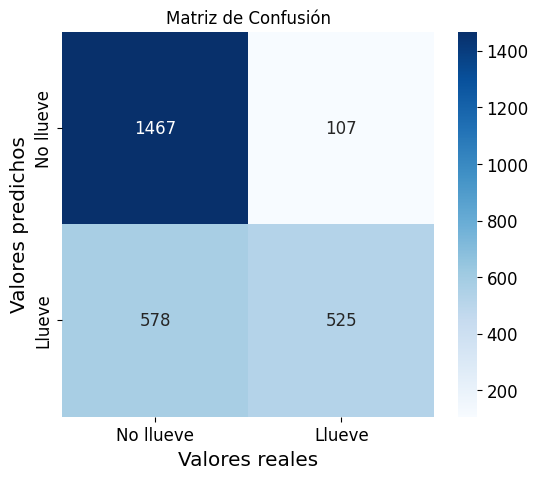

In [289]:
y_pred = best_model_nn_clas.predict(X_test)
y_pred = (y_pred >= best_threshold).astype(int)

best_params = study.best_params
print(best_params)
tpr_nn, f1_nn = logreg_metrics(y_test,y_pred)
matriz_conf(y_test,y_pred)

##### **Insights obtenidos**

Se obtiene un modelo superador que acertará en un 83% en los días lluviosos, a costa de una mala precisión en cuanto a lluvia = True, acertando correctamente el 48% de las veces que pronostica lluvia.
Sin embargo, la mayoría de los días en los cuales no se pronostica lluvia, efectivamente no llueve.

#### Resolución del problema de Regresión

In [290]:
def objective_regresor(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 10, 100) # la cantidad de neuronas de cada capa también se puede pasar como hiperparámetro
        # activations = trial.suggest_categorical(f'')
        model.add(Dense(num_units, activation='relu')) # capas densas con activacion ReLU
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0, 0.6)
        model.add(Dropout(dropout_rate))
    # capa de salida
    model.add(Dense(1, activation='linear'))
    # compilar
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    # entrenar
    epochs = trial.suggest_int('epochs', 10, 100)
    batch_size = trial.suggest_int('batch_size', 256, 512)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluar
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [291]:
X_train, y_train, X_test, y_test = split(df_train, df_test,'regresion')
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

best_model_nn_reg, study = nn_model(X_train, y_train,X_test, y_test,'regresion')

[I 2025-02-24 11:13:59,187] A new study created in memory with name: no-name-0fbe7044-342a-4e74-a112-4db475f0dbae


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 41.9784 - mean_squared_error: 41.9784 - val_loss: 43.6175 - val_mean_squared_error: 43.6175
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.9052 - mean_squared_error: 34.9052 - val_loss: 39.6273 - val_mean_squared_error: 39.6273
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.6827 - mean_squared_error: 32.6827 - val_loss: 38.3590 - val_mean_squared_error: 38.3590
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.9449 - mean_squared_error: 31.9449 - val_loss: 37.6017 - val_mean_squared_error: 37.6017
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.5878 - mean_squared_error: 31.5878 - val_loss: 36.9323 - val_mean_squared_error: 36.9323
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.7054 - mean_squared_error: 30.7054 - val_loss: 36.3807 - val_mean_squared_error: 36.3807
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.0517 - mean_squared_error: 30.05

[I 2025-02-24 11:14:12,829] Trial 0 finished with value: 33.378326416015625 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.1532843542543268, 'n_units_layer_1': 46, 'dropout_rate_layer_1': 0.2263890586146744, 'epochs': 100, 'batch_size': 360}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 41.9850 - mean_squared_error: 41.9850 - val_loss: 42.7597 - val_mean_squared_error: 42.7597
Epoch 2/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.2036 - mean_squared_error: 36.2036 - val_loss: 38.2364 - val_mean_squared_error: 38.2364
Epoch 3/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.0489 - mean_squared_error: 33.0489 - val_loss: 36.8190 - val_mean_squared_error: 36.8190
Epoch 4/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.4405 - mean_squared_error: 31.4405 - val_loss: 36.2564 - val_mean_squared_error: 36.2564
Epoch 5/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.6088 - mean_squared_error: 31.6088 - val_loss: 35.8558 - val_mean_squared_error: 35.8558
Epoch 6/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.4174 - mean_squared_error: 32.4174 - val_loss: 35.5263 - val_mean_squared_error: 35.5263
Epoch 7/92
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.0522 - mean_squared_error: 30.0522 - va

[I 2025-02-24 11:14:26,357] Trial 1 finished with value: 35.1203498840332 and parameters: {'num_layers': 3, 'n_units_layer_0': 79, 'dropout_rate_layer_0': 0.1860056092111992, 'n_units_layer_1': 41, 'dropout_rate_layer_1': 0.21105889049793744, 'n_units_layer_2': 23, 'dropout_rate_layer_2': 0.5835988108304702, 'epochs': 92, 'batch_size': 399}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 42.8405 - mean_squared_error: 42.8405 - val_loss: 44.4491 - val_mean_squared_error: 44.4491
Epoch 2/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.8790 - mean_squared_error: 35.8790 - val_loss: 40.4473 - val_mean_squared_error: 40.4473
Epoch 3/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.2816 - mean_squared_error: 33.2816 - val_loss: 39.1570 - val_mean_squared_error: 39.1570
Epoch 4/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.2551 - mean_squared_error: 32.2551 - val_loss: 38.4272 - val_mean_squared_error: 38.4272
Epoch 5/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.3507 - mean_squared_error: 31.3507 - val_loss: 37.8338 - val_mean_squared_error: 37.8338
Epoch 6/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.0811 - mean_squared_error: 31.0811 - val_loss: 37.3655 - val_mean_squared_error: 37.3655
Epoch 7/45
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.5785 - mean_squared_error: 30.5785 - va

[I 2025-02-24 11:14:32,360] Trial 2 finished with value: 34.50477600097656 and parameters: {'num_layers': 1, 'n_units_layer_0': 90, 'dropout_rate_layer_0': 0.40474383949335835, 'epochs': 45, 'batch_size': 386}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 37.9007 - mean_squared_error: 37.9007 - val_loss: 39.3601 - val_mean_squared_error: 39.3601
Epoch 2/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4862 - mean_squared_error: 31.4862 - val_loss: 37.0886 - val_mean_squared_error: 37.0886
Epoch 3/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.1259 - mean_squared_error: 30.1259 - val_loss: 35.8317 - val_mean_squared_error: 35.8317
Epoch 4/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.2471 - mean_squared_error: 29.2471 - val_loss: 35.0575 - val_mean_squared_error: 35.0575
Epoch 5/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.6133 - mean_squared_error: 28.6133 - val_loss: 34.5400 - val_mean_squared_error: 34.5400
Epoch 6/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.4804 - mean_squared_error: 28.4804 - val_loss: 34.1530 - val_mean_squared_error: 34.1530
Epoch 7/39
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8455 - mean_squared_error: 27.8455 - va

[I 2025-02-24 11:14:39,134] Trial 3 finished with value: 33.57449722290039 and parameters: {'num_layers': 2, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.3428238414233559, 'n_units_layer_1': 70, 'dropout_rate_layer_1': 0.03135521466390556, 'epochs': 39, 'batch_size': 270}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 45.7524 - mean_squared_error: 45.7524 - val_loss: 47.2915 - val_mean_squared_error: 47.2915
Epoch 2/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.0673 - mean_squared_error: 38.0673 - val_loss: 42.3544 - val_mean_squared_error: 42.3544
Epoch 3/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.7662 - mean_squared_error: 34.7662 - val_loss: 40.0063 - val_mean_squared_error: 40.0063
Epoch 4/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.8081 - mean_squared_error: 32.8081 - val_loss: 38.9627 - val_mean_squared_error: 38.9627
Epoch 5/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.4654 - mean_squared_error: 32.4654 - val_loss: 38.3939 - val_mean_squared_error: 38.3939
Epoch 6/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.7574 - mean_squared_error: 31.7574 - val_loss: 37.9260 - val_mean_squared_error: 37.9260
Epoch 7/74
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.4018 - mean_squared_error: 31.4018 - va

[I 2025-02-24 11:14:48,182] Trial 4 finished with value: 34.1933479309082 and parameters: {'num_layers': 1, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.5628091337654352, 'epochs': 74, 'batch_size': 444}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 41.0036 - mean_squared_error: 41.0036 - val_loss: 40.1299 - val_mean_squared_error: 40.1299
Epoch 2/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0895 - mean_squared_error: 33.0895 - val_loss: 37.6295 - val_mean_squared_error: 37.6295
Epoch 3/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.0359 - mean_squared_error: 31.0359 - val_loss: 36.2735 - val_mean_squared_error: 36.2735
Epoch 4/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.8992 - mean_squared_error: 29.8992 - val_loss: 35.4667 - val_mean_squared_error: 35.4667
Epoch 5/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.2797 - mean_squared_error: 29.2797 - val_loss: 34.8609 - val_mean_squared_error: 34.8609
Epoch 6/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.0587 - mean_squared_error: 29.0587 - val_loss: 34.5936 - val_mean_squared_error: 34.5936
Epoch 7/64
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.4171 - mean_squared_error: 28.4171 - va

[I 2025-02-24 11:14:58,245] Trial 5 finished with value: 33.676910400390625 and parameters: {'num_layers': 2, 'n_units_layer_0': 94, 'dropout_rate_layer_0': 0.2438521460044845, 'n_units_layer_1': 72, 'dropout_rate_layer_1': 0.3899495208534373, 'epochs': 64, 'batch_size': 313}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 43.7509 - mean_squared_error: 43.7509 - val_loss: 45.0963 - val_mean_squared_error: 45.0963
Epoch 2/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.3185 - mean_squared_error: 37.3185 - val_loss: 40.3041 - val_mean_squared_error: 40.3041
Epoch 3/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.9666 - mean_squared_error: 34.9666 - val_loss: 38.8049 - val_mean_squared_error: 38.8049
Epoch 4/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.6278 - mean_squared_error: 33.6278 - val_loss: 37.6574 - val_mean_squared_error: 37.6574
Epoch 5/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.4884 - mean_squared_error: 32.4884 - val_loss: 36.9367 - val_mean_squared_error: 36.9367
Epoch 6/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.7877 - mean_squared_error: 31.7877 - val_loss: 36.2603 - val_mean_squared_error: 36.2603
Epoch 7/21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.0152 - mean_squared_error: 31.0152 - va

[I 2025-02-24 11:15:02,203] Trial 6 finished with value: 33.54469680786133 and parameters: {'num_layers': 3, 'n_units_layer_0': 89, 'dropout_rate_layer_0': 0.478030357968641, 'n_units_layer_1': 49, 'dropout_rate_layer_1': 0.5507269314950339, 'n_units_layer_2': 81, 'dropout_rate_layer_2': 0.435450167009563, 'epochs': 21, 'batch_size': 491}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 42.2316 - mean_squared_error: 42.2316 - val_loss: 43.0616 - val_mean_squared_error: 43.0616
Epoch 2/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.8680 - mean_squared_error: 34.8680 - val_loss: 39.0083 - val_mean_squared_error: 39.0083
Epoch 3/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.5175 - mean_squared_error: 32.5175 - val_loss: 37.7171 - val_mean_squared_error: 37.7171
Epoch 4/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.9859 - mean_squared_error: 30.9859 - val_loss: 36.9736 - val_mean_squared_error: 36.9736
Epoch 5/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.7787 - mean_squared_error: 30.7787 - val_loss: 36.4107 - val_mean_squared_error: 36.4107
Epoch 6/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.5848 - mean_squared_error: 30.5848 - val_loss: 35.9091 - val_mean_squared_error: 35.9091
Epoch 7/86
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.2934 - mean_squared_error: 30.2934 - va

[I 2025-02-24 11:15:15,142] Trial 7 finished with value: 34.38459014892578 and parameters: {'num_layers': 2, 'n_units_layer_0': 36, 'dropout_rate_layer_0': 0.3700388488335085, 'n_units_layer_1': 52, 'dropout_rate_layer_1': 0.153203348606738, 'epochs': 86, 'batch_size': 301}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 41.9843 - mean_squared_error: 41.9843 - val_loss: 43.4229 - val_mean_squared_error: 43.4229
Epoch 2/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.1794 - mean_squared_error: 35.1794 - val_loss: 39.7627 - val_mean_squared_error: 39.7627
Epoch 3/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0490 - mean_squared_error: 33.0490 - val_loss: 38.6490 - val_mean_squared_error: 38.6490
Epoch 4/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.6629 - mean_squared_error: 31.6629 - val_loss: 37.8750 - val_mean_squared_error: 37.8750
Epoch 5/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.9757 - mean_squared_error: 30.9757 - val_loss: 37.2913 - val_mean_squared_error: 37.2913
Epoch 6/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.3383 - mean_squared_error: 30.3383 - val_loss: 36.8764 - val_mean_squared_error: 36.8764
Epoch 7/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.2927 - mean_squared_error: 30.2927 - va

[I 2025-02-24 11:15:17,984] Trial 8 finished with value: 35.46736526489258 and parameters: {'num_layers': 1, 'n_units_layer_0': 70, 'dropout_rate_layer_0': 0.2874697470257717, 'epochs': 16, 'batch_size': 291}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 45.7664 - mean_squared_error: 45.7664 - val_loss: 47.4014 - val_mean_squared_error: 47.4014
Epoch 2/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.2516 - mean_squared_error: 38.2516 - val_loss: 42.5093 - val_mean_squared_error: 42.5093
Epoch 3/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.6924 - mean_squared_error: 34.6924 - val_loss: 40.3031 - val_mean_squared_error: 40.3031
Epoch 4/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.4383 - mean_squared_error: 33.4383 - val_loss: 39.3864 - val_mean_squared_error: 39.3864
Epoch 5/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.5510 - mean_squared_error: 32.5510 - val_loss: 38.8246 - val_mean_squared_error: 38.8246
Epoch 6/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.8544 - mean_squared_error: 31.8544 - val_loss: 38.2943 - val_mean_squared_error: 38.2943
Epoch 7/97
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.6782 - mean_squared_error: 31.6782 - va

[I 2025-02-24 11:15:29,608] Trial 9 finished with value: 33.985206604003906 and parameters: {'num_layers': 1, 'n_units_layer_0': 53, 'dropout_rate_layer_0': 0.3241777375622531, 'epochs': 97, 'batch_size': 406}. Best is trial 0 with value: 33.378326416015625.


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38.9344 - mean_squared_error: 38.9344 - val_loss: 41.0845 - val_mean_squared_error: 41.0845
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.1551 - mean_squared_error: 34.1551 - val_loss: 38.8246 - val_mean_squared_error: 38.8246
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.1644 - mean_squared_error: 32.1644 - val_loss: 37.9469 - val_mean_squared_error: 37.9469
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.6743 - mean_squared_error: 31.6743 - val_loss: 37.2495 - val_mean_squared_error: 37.2495
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.6868 - mean_squared_error: 30.6868 - val_loss: 36.6801 - val_mean_squared_error: 36.6801
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.2015 - mean_squared_error: 30.2015 - val_loss: 36.1894 - val_mean_squared_error: 36.1894
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.9628 - mean_squared_error: 29.96

In [292]:
best_params = study.best_params
print(best_params)
# Se guardan las predicciones del modelo
y_pred_train = best_model_nn_reg.predict(X_train)
y_pred_test = best_model_nn_reg.predict(X_test)

# Se calcula el error de train del modelo con rmse para mantener la misma escala que la variable a predecir
rmse_nn_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_nn_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"El error rmse_nn_train es: {rmse_nn_train}")
print(f"El error rmse_nn_test es: {rmse_nn_test}")

R2_nn_train = metrics.r2_score(y_train, y_pred_train)
print(f"El valor de R2_nn_train: {R2_nn_train}")
R2_nn_test = metrics.r2_score(y_test, y_pred_test)
print(f"El valor de R2_nn_test: {R2_nn_test}")

{'num_layers': 2, 'n_units_layer_0': 30, 'dropout_rate_layer_0': 0.1532843542543268, 'n_units_layer_1': 46, 'dropout_rate_layer_1': 0.2263890586146744, 'epochs': 100, 'batch_size': 360}
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
El error rmse_nn_train es: 5.049184972938215
El error rmse_nn_test es: 5.851090320607053
El valor de R2_nn_train: 0.44455880386388347
El valor de R2_nn_test: 0.282051296817185


##### **Insights obtenidos**

Se observa una ligera mejora en los valores del error y la varianza explicada. El último modelo es significativamente más complejo, y siguiendo el principio de parcimonia, puede no justificarse su implementación.   

#### SHAP: Explicabilidad de los modelos de redes

Se utiliza SHAP para explicar la contribución de las variables en los modelos de regresión y clasificación. SHAP asigna un valor de importancia a cada característica, indicando cómo influye en las predicciones del modelo, lo que permite interpretar y entender mejor su comportamiento, incluso en arquitecturas complejas como las redes neuronales.

In [293]:
# Establece el estilo de matplotlib
plt.rcdefaults()
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
})

plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

##### Explicabilidad para Regresión

In [294]:
X_train, y_train, X_test, y_test = split(df_train, df_test, 'regresion')
feature_names = X_train.columns.values

# Reducir la cantidad de muestras para reducir el tiempo de ejecución de SHAP
n_train = int(len(df_train) * 0.02)
n_test = int(len(df_test) * 0.02)
# Se resetea el índice para que sean consecutivos y comiencen en cero
X_train = X_train.sample(n=n_train, random_state=semilla).reset_index(drop=True)
X_test = X_test.sample(n=n_test, random_state=semilla).reset_index(drop=True)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir los arrays escalados de nuevo a DataFrames utilizando los nombres de las características
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Crear un objeto explainer SHAP usando KernelExplainer
explainer = shap.KernelExplainer(best_model_nn_reg, X_train_scaled.values, feature_names=feature_names)

# Calcular los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled.values)
shap_values = np.squeeze(shap_values)

# Verificar la forma de los valores SHAP
print(shap_values.shape)

Using 303 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 53/53 [01:42<00:00,  1.93s/it]

(53, 22)


###### Interpretabilidad local

Se generan dos gráficas para interpretar la explicabilidad a nivel local, específicamente para la instancia correspondiente al index del conjunto de datos. De igual manera, es destacable que su aplicación resulta especialmente útil en entornos productivos.

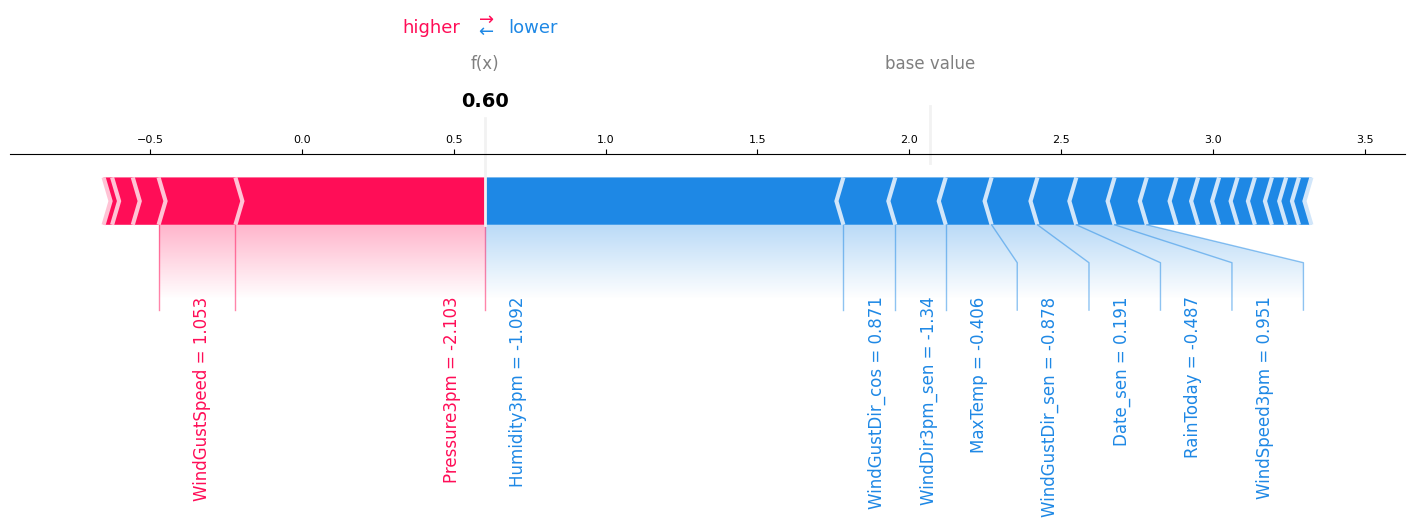

In [295]:
# Se selecciona un índice aleatorio
index=25
shap_values[index]

rounded_shap_values = np.round(shap_values[index], 3)
rounded_X_test = np.round(X_test_scaled.iloc[index], 3)

# Genera la gráfica
shap.force_plot(explainer.expected_value, rounded_shap_values, rounded_X_test,
                feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=90)


El gráfico anterior es un gráfico de fuerza, que muestra cómo las características contribuyen a la predicción del valor de la variable target RainfallTomorrow. Se puede observar cómo impactan las distintas variables de manera positiva (en rojo) y negativa (en azul).
Las variables con mayor incidencia son las descritas en el gráfico, para el caso particular del elemento en la posición index.

Se observa un mayor peso de las variables que empujan hacia valores más bajos.

Principales variables con incidencia positiva:
* Date_cos
* Pressure3pm
* WindGustSpeed

Principales variables con incidencia negativa:
* Humidity3pm
* WindSpeed3pm
* Cloud3pm
* WindSpeed9am
* WindGustDir_sen
* WindGustDir_cos

Es así que, por ejemplo, valores más altos de WindGustSpeed tienen un peso positivo sobre la variable RainfallTomorrow.

En contraposición, valores altos para Humidity3pm incidirán de manera negativa en el valor de la variable objetivo.

Gráfico de valores SHAP


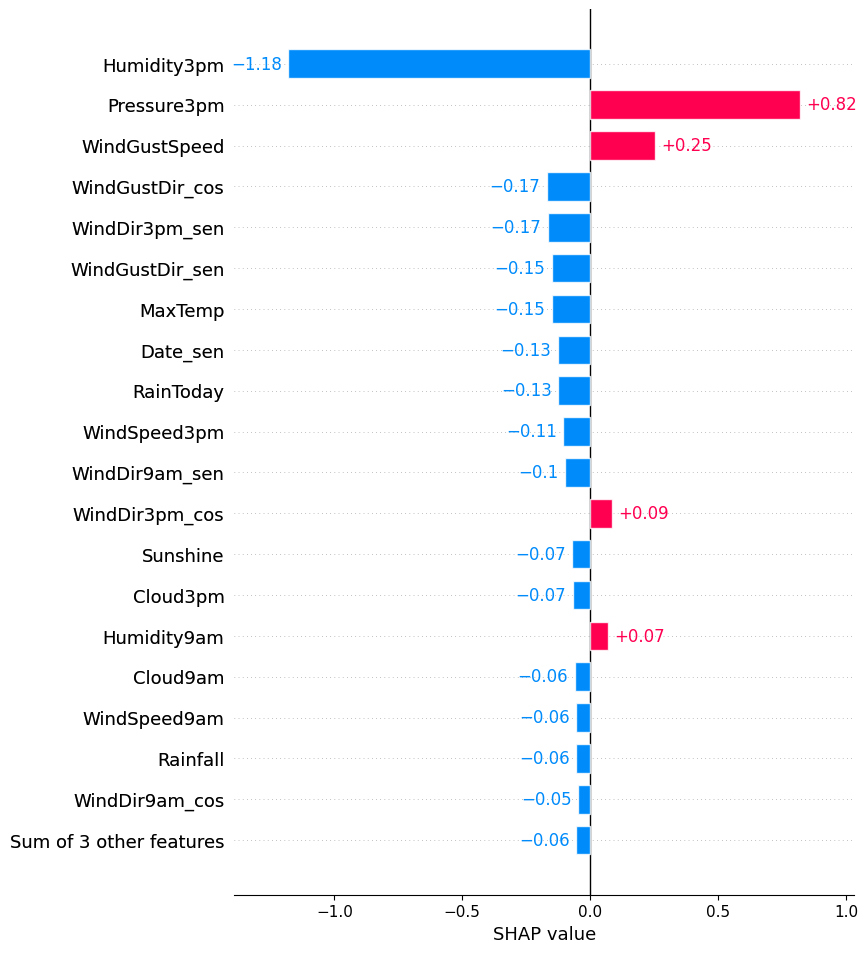

In [296]:
explanation = shap.Explanation(rounded_shap_values, base_values=explainer.expected_value, feature_names=feature_names)
print("Gráfico de valores SHAP")
shap.plots.bar(explanation, max_display=20)

El gráfico anterior es un gráfico de resumen de SHAP para la instancia individual elegida, donde se muestra cómo las características específicas contribuyen a la predicción en particular.
Este gráfico permite observar de manera más detallada el mismo comportamiento de las variables explicativas.

###### Interpretabilidad global

Se analiza la incidencia de las variables explicativas a nivel global, es decir para todas las muestras del conjunto de datos.

Gráfico de valores SHAP


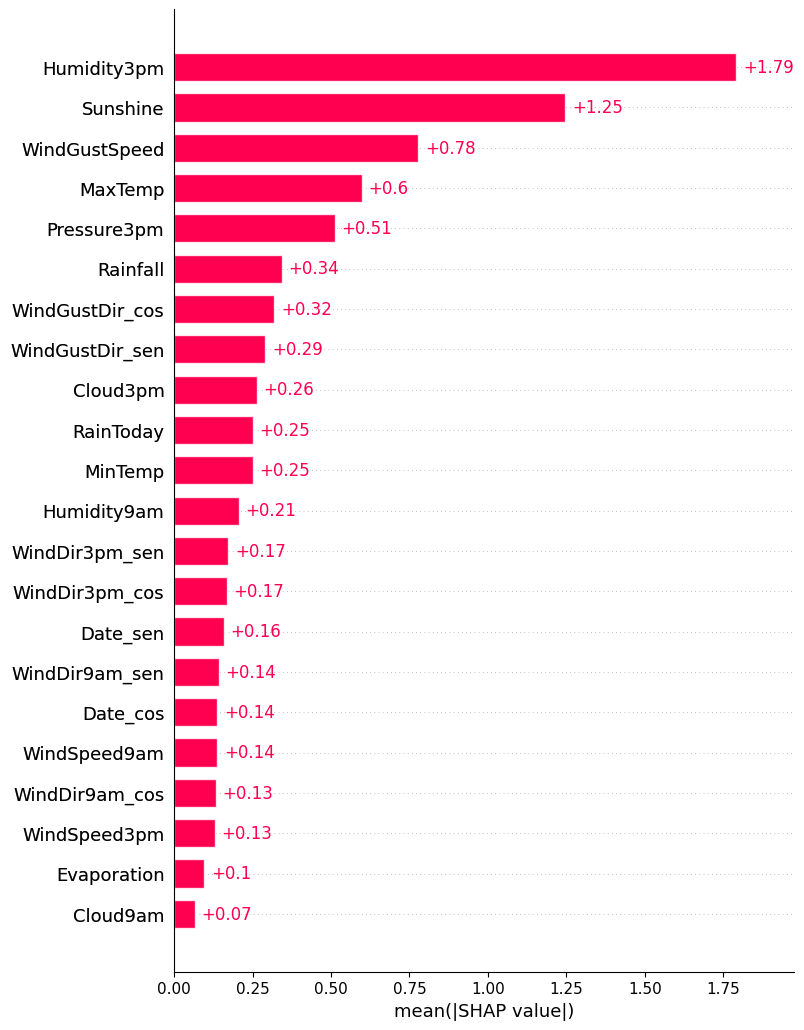

In [297]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)
print('Gráfico de valores SHAP')
shap.plots.bar(explanation, max_display=30)

Se observan diferencias con respecto a la interpretabilidad local. En el gráfico de importancia global de las variables, todas las variables explicativas están ordenadas según su contribución promedio al modelo.
En primer lugar todas las variables inciden de manera positiva en el valor de la variable objetivo.

La variable Humidity3pm es la de mayor contribución en ambos análisis (local y global), pero en sentidos opuestos.

Principales variables con incidencia positiva:
* Humidity3pm
* Sunshine
* WindGustSpeed

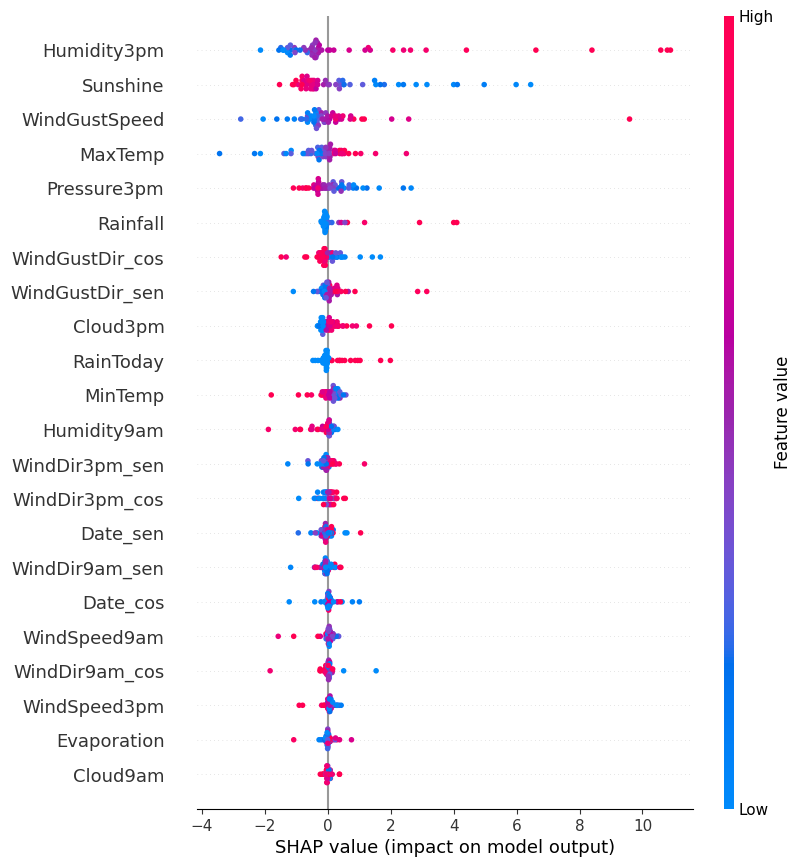

In [298]:
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 'large', 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
shap.plots.beeswarm(explanation, max_display=30)

La gráfica muestra las variables explicativas ordenadas según su importancia global en el modelo, considerando su impacto en la predicción de la probabilidad de lluvia para el día siguiente ("RainfallTomorrow"). A continuación, se analizan las principales variables:

En primer lugar, se encuentra la variable **Humidity3pm**, donde los valores más altos tienen una incidencia positiva en la probabilidad de lluvia al día siguiente, mientras que los valores más bajos tienen un impacto negativo. Esto sugiere que una mayor humedad en la tarde está asociada con una mayor probabilidad de lluvia al día siguiente.

En segundo lugar, aparece la variable **Sunshine**, donde los valores más altos tienen una incidencia negativa en la probabilidad de lluvia al día siguiente, y los valores más bajos tienen un impacto positivo. Esto es coherente con la expectativa de que días más soleados están asociados con una menor probabilidad de lluvia al día siguiente.

La variable **WindGustSpeed** muestra que los valores más altos tienen una incidencia positiva en la probabilidad de lluvia al día siguiente, mientras que los valores más bajos tienen un impacto negativo. Esto indica que ráfagas de viento más fuertes pueden estar relacionadas con una mayor posibilidad de lluvia.

La variable **Rainfall** tiene un comportamiento similar, donde los valores más altos aumentan la probabilidad de lluvia al día siguiente, mientras que los valores más bajos la disminuyen. Esto es consistente con la idea de que la lluvia actual puede ser un indicador de condiciones meteorológicas que favorecen la lluvia al día siguiente.

La variable **Cloud3pm** también muestra un patrón donde los valores más altos (mayor nubosidad) tienen una incidencia positiva en la probabilidad de lluvia al día siguiente, mientras que los valores más bajos (menor nubosidad) tienen un impacto negativo. Esto sugiere que una mayor nubosidad en la tarde está asociada con una mayor probabilidad de lluvia al día siguiente.

En resumen, las variables más importantes en el modelo están relacionadas con la humedad, el sol, la velocidad del viento, la lluvia y la nubosidad.

##### Explicabilidad para Clasificación

In [299]:
X_train, y_train, X_test, y_test = split(df_train, df_test, 'clasificacion')
feature_names = X_train.columns.values

# Aplicar oversampling
oversampler = RandomOverSampler(random_state=semilla)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Reducir la cantidad de muestras para reducir el tiempo de ejecución de SHAP
n_train = int(len(df_train) * 0.02)
n_test = int(len(df_test) * 0.02)
X_train = X_train.sample(n=n_train, random_state=semilla).reset_index(drop=True) # se resetea el índice para que sean consecutivos y comiencen en cero
X_test = X_test.sample(n=n_test, random_state=semilla).reset_index(drop=True)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir los arrays escalados de nuevo a DataFrames de pandas utilizando los nombres de las características
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Crear un objeto explainer SHAP usando KernelExplainer
explainer = shap.KernelExplainer(best_model_nn_clas, X_train_scaled.values)

# Calcular los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled.values)
shap_values = np.squeeze(shap_values)
print(shap_values.shape)

Using 303 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 53/53 [01:44<00:00,  1.97s/it]

(53, 22)


###### Interpretabilidad local

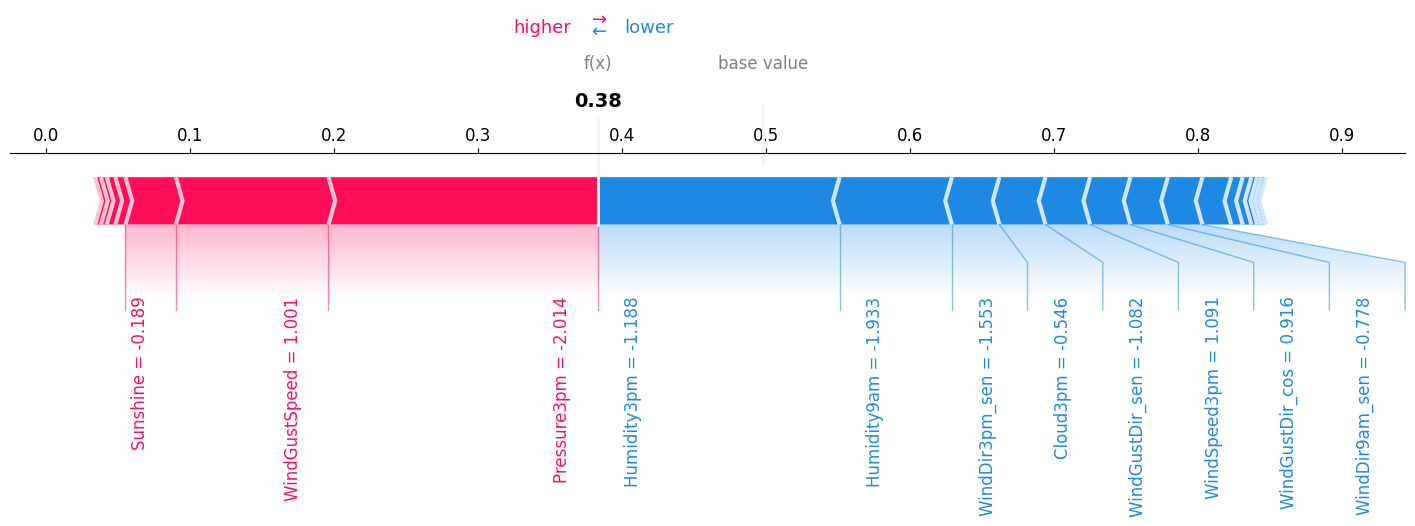

In [300]:
index=25
shap_values[index]

rounded_shap_values = np.round(shap_values[index], 3)
rounded_X_test = np.round(X_test_scaled.iloc[index], 3)

# Genera el gráfico de SHAP con valores redondeados
shap.force_plot(explainer.expected_value, rounded_shap_values, rounded_X_test,
                feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=90)

Del gráfico de fuerza anterior se puede observar cómo impactan las variables de manera positiva (en rojo) y negativa (en azul).
Las variables con mayor incidencia son las descritas en el gráfico, para el caso particular del elemento en la posición index.

Resultan más las variables que empujan la predicción hacia la clase 0 (RainTomorrow=False).

Principales variables con incidencia positiva:
* Sunshine
* WindGustSpeed
* Pressure3pm

Principales variables con incidencia negativa:
* Humidity3pm
* Humidity9am  
* WindDir3pm_sen
* Otras
      
Es importante destacar que la mayoría de las variables obtenidas también son relevantes para el análisis local en el modelo de regresión.

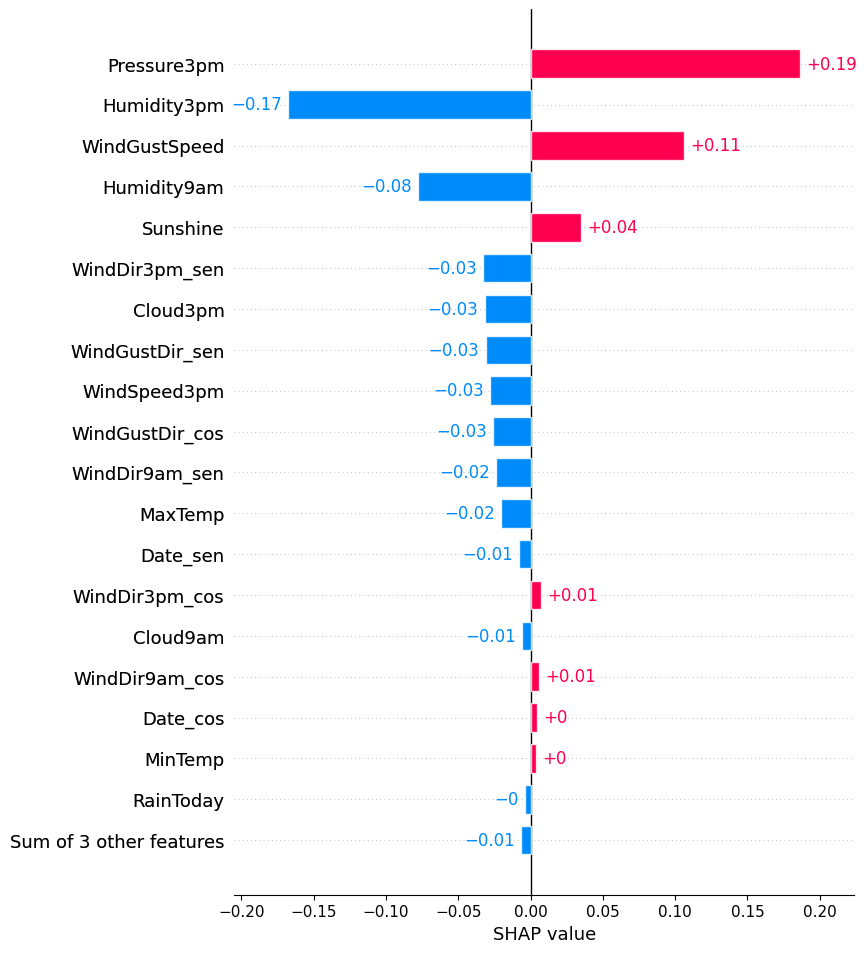

In [301]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=20)

La gráfica anterior permite observar con más detalle lo expuesto previamente.

###### Interpretabilidad global

Gráfico de valores SHAP


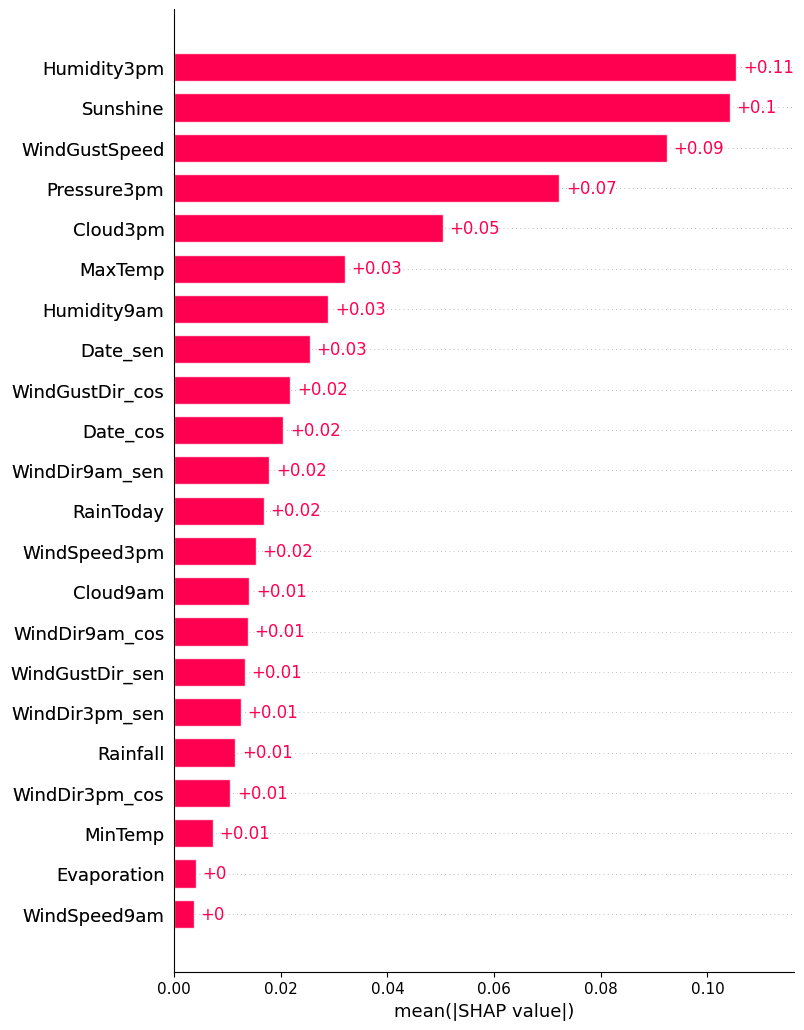

In [302]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)
print('Gráfico de valores SHAP')
shap.plots.bar(explanation, max_display=30)

A continuación, se presentan las conclusiones clave:

1. **Humidity3pm** es la variable más importante, con un valor de +0.11. Esto indica que la humedad en la tarde tiene un impacto significativo en la predicción del modelo, sugiriendo que niveles más altos de humedad están asociados con una mayor probabilidad de lluvia al día siguiente.

2. **Sunshine** también es una variable importante, con un valor de +0.1.

3. **WindGustSpeed** tiene un valor de +0.09, lo que indica que la velocidad de las ráfagas de viento es un factor relevante.

Las variables más importantes para el modelo son **Humidity3pm**, **Sunshine**, y **WindGustSpeed**. Estas variables están relacionadas con condiciones meteorológicas que influyen en la probabilidad de lluvia al día siguiente.

#### Explicabilidad del modelo: Conclusiones

En cuanto al análisis global, son lógicas las incidencias de las variables de mayor peso en las variables target. Por ejemplo, es razonable suponer que valores mayores de Sunshine impactan negativamente en la probabilidad de que llueva al día siguiente.

Por otro lado se observa que las variables de mayor peso para predecir las variables target son las mismas para el modelo de regresión y clasificación.
* Humidity3pm
* Sunshine
* WindGustSpeed

### Comparación de modelos

#### Regresión

In [303]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_reg = df_comparacion_reg.copy()
df_comparacion_reg.loc[len(df_comparacion_reg)] = ['Redes Neuronales', rmse_nn_train, np.nan, rmse_nn_test, R2_nn_train, np.nan, R2_nn_test]
df_comparacion_reg

,Modelo,Train RMSE,Val RMSE,Test RMSE,Train R2,Val R2,Test R2
0,OLS,6.010412,6.005909,6.193535,0.207940,0.236659,0.195554
1,GD,6.011354,6.010504,6.195455,0.207692,0.235491,0.195055
2,SGD,6.011354,6.010504,6.195455,0.207692,0.235491,0.195055
3,GDMB,6.012450,6.012347,6.203139,0.207403,0.235022,0.193057
4,Ridge,6.007773,NaN,6.187358,0.213638,NaN,0.197158
5,Lasso,6.008794,NaN,6.190489,0.213371,NaN,0.196345
6,Elastic-net,6.007772,NaN,6.187378,0.213638,NaN,0.197152
7,Redes Neuronales,5.049185,NaN,5.851090,0.444559,NaN,0.282051


En la tabla anterior se resumen todos los modelos desarrollados para el problema de regresión. RMSE tiene la ventaja de ser un valor fácilmente interpretable al tratarse de mm de lluvia. La métrica R2 también es sencilla de analizar, ya que su variación es de 0 a 1, siendo R2=1 el valor para un modelo con una capacidad perfecta de predicción.

En este análisis interesa particularmente el valor de test R2. Se puede observar que el modelo de redes logra capturar más variabilidad, pero aún así no alcanza una calidad aceptable de predicción (R2>0.6 por ejemplo). Hay que considerar también que se trata de una solución que agrega considerable complejidad.  

#### Clasificación

In [304]:
# Crear el DataFrame con los modelos y sus métricas
df_comparacion_clas = df_comparacion_logreg.copy()
df_comparacion_clas.loc[len(df_comparacion_clas)] = ['Redes Neuronales', best_threshold, tpr_nn]
df_comparacion_clas

,Modelo,Umbral,TPR
0,LogReg_Balanceado,0.500000,0.759
1,LogReg_OverSamp,0.500000,0.759
2,LogReg_OverSamp_Umbral,0.443015,0.8
3,Redes Neuronales,0.400000,0.830696


En la tabla anterior se resumen todos los modelos desarrollados para la resolución del problema de clasificación.

El enfoque adoptado ha sido el de maximizar TPR (recall), es decir, maximizar la detección de verdaderos positivos (días de lluvia). Teniendo esto en consideración, el modelo de Redes Neuronales resulta el mejor, aunque por poco margen.

### MLOps

Se productivizó exitosamente un modelo de regresión lineal distinto al expuesto en esta notebook. 

Diferencias principales: 
* Se imputaron faltantes por la moda de cada columna en lugar de la compleja implementación de las funciones de distancia geográfica. 
* No hay tratamiento de atípicos sobre el modelo productivizado, dado que la eliminación del 2% de los outliers generaba un impacto negativo sobre el error.

*Importante:* Se destaca que la puesta en producción fue exploratoria, ya que las experimentaciones no corresponden a entornos productivos. 

### Conclusiones finales

En este trabajo práctico, se desarrollaron una serie de modelos para la predicción de lluvia en Australia, empleando técnicas de Machine Learning y Deep Learning. A lo largo del proyecto, se llevó a cabo un análisis exhaustivo de los datos, se implementaron modelos de regresión y clasificación, y se optimizaron hiperparámetros con el objetivo de mejorar la precisión de las predicciones. Para ello, se utilizaron herramientas como scikit-learn y TensorFlow para el entrenamiento de redes neuronales.

Durante el desarrollo, se buscó mejorar la performance de los modelos mediante la evaluación de diversas métricas, según el problema en cuestión. Además, se aplicaron técnicas de optimización y validación cruzada para ajustar los modelos, evitando el sobreajuste y buscando mejorar su capacidad predictiva. Sin embargo, a pesar de estos esfuerzos, no se logró alcanzar un modelo con un rendimiento satisfactorio, lo que sugiere que podrían requerirse enfoques más avanzados, como algoritmos basados en árboles y ensambles, como por ejemplo RandomForest, XGBoost o LGBM. A su vez, se hubiese podido continuar la exploración con redes neuronales de haber contado con más tiempo.

Aunque los resultados no fueron los esperados, el proceso permitió identificar áreas de mejora y reforzar la comprensión de los desafíos asociados a la predicción meteorológica, sentando las bases para futuras iteraciones y mejoras. 

A modo de cierre, el aprendizaje que me gustaría recalcar es la necesidad de incorporar la perspectiva del despliegue en producción desde las etapas más tempranas al abordar cualquier desafío. Esto implica anticipar, desde el inicio, los requisitos y consideraciones técnicas que garantizarán una implementación eficiente y sostenible de las soluciones.